# Import libraries

In [ ]:
# Import packages
import tensorflow as tf
import keras
import numpy as np
#import sklearn as sk
import pandas as pd
import PIL
import pathlib
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
import requests
!pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
#from sklearn.preprocessing import Normalizer
from keras import backend as K
from keras.callbacks import ModelCheckpoint
#from keras.applications import resnet50
import sys
!pip install rarfile
from rarfile import RarFile
!pip install segmentation-models
import segmentation_models as sm
!pip install git+https://github.com/davej23/image-segmentation-keras.git
from keras_segmentation.models import segnet
from keras.applications import vgg16
from sklearn.metrics import *
!pip install rioxarray
import rioxarray as rxr
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import folium
import rasterio
from osgeo import gdal
!pip install geopandas fiona
import geopandas
import fiona
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
!pip install pyshp
import shapefile

# Ingest and Prepare Data

## Images

In [ ]:
# Connect to Google Drive where data is stored
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
download = True

In [ ]:
# Tall plant mask
full_mask_og = np.array(rxr.open_rasterio('drive/MyDrive/tall_frailejones_raster1.tif'))[0:1,:,:]/100
full_mask_og = full_mask_og.T
#2500:9668, 2500:9668
#2500:12740:,4000:10144
#3012:12740:,4000:10144, :
full_mask = full_mask_og[5000:13192, 5000:13192, :]

# Short plant mask
full_mask_og_short = np.array(rxr.open_rasterio('drive/MyDrive/short_frailejones_raster1.tif'))[0:1,:,:]/100
full_mask_og_short = full_mask_og_short.T
full_mask_short = full_mask_og_short[5000:13192, 5000:13192, :]

# Split masks
# Break into 512x512x1 masks, delete ones which are all 0s
all_masks = []
for i in range(full_mask.shape[0] // 512):
  for j in range(full_mask.shape[1] // 512):
    all_masks.append(full_mask[512*(i):512*(i+1), 512*(j):512*(j+1), :].reshape(512,512,1))

# Split short masks
# Break into 512x512x1 masks, delete ones which are all 0s
all_short_masks = []
for i in range(full_mask_short.shape[0] // 512):
  for j in range(full_mask_short.shape[1] // 512):
    all_short_masks.append(full_mask_short[512*(i):512*(i+1), 512*(j):512*(j+1), :].reshape(512,512,1))

masks = []
masks_short = []
ind = []
tall_tot = []
short_tot = []
for i in range(len(all_masks)):
  if np.sum(all_masks[i]) > 0 or np.sum(all_short_masks[i]) > 0:
    masks.append(all_masks[i])
    masks_short.append(all_short_masks[i])
    tall_tot.append([i, np.sum(all_masks[i])])
    short_tot.append([i, np.sum(all_short_masks[i])])
    ind.append(i)


## Find masks with most tall plants
tall_tot = sorted(tall_tot, key=lambda x: x[1], reverse=True)
tall_tot = tall_tot[0:30]
tall_ind = [n[0] for n in tall_tot]

## Find masks with most short plants
short_tot = [n for n in short_tot if n[0] not in tall_ind]
short_tot = sorted(short_tot, key=lambda x: x[1], reverse=True)
short_tot = short_tot[0:30]
short_ind = [n[0] for n in short_tot]
  
ind = tall_ind + short_ind
# Read image data and find those with most plants using indices from masks
full_img_og = np.array(rxr.open_rasterio('drive/MyDrive/DUI-01-1_ortho.tif'))
full_img_og = full_img_og.T
full_img = full_img_og[5000:13192, 5000:13192, :]

# Break into smaller subimages
all_images = []
for i in range(full_img.shape[0] // 512):
  for j in range(full_img.shape[1] // 512):
    all_images.append(full_img[512*(i):512*(i+1), 512*(j):512*(j+1), :].reshape(512,512,3))

# Find those with most plants
images = []
tall_masks2 = []
short_masks2 = []
for n in ind:
  images.append(all_images[n])
  tall_masks2.append(all_masks[n])
  short_masks2.append(all_short_masks[n])
print(len(images))

images = [n/255 for n in images] # Normalise images




60


In [ ]:
if download == False:
  !cp /content/drive/MyDrive/Paramo/training_images.npy /content/
  !cp /content/drive/MyDrive/Paramo/training_masks.npy /content/
  !cp /content/drive/MyDrive/Paramo/validation_images.npy /content/
  !cp /content/drive/MyDrive/Paramo/validation_masks.npy /content/
  training_images = np.load('training_images.npy')
  training_masks = np.load('training_masks.npy')
  validation_images = np.load('validation_images.npy')
  validation_masks = np.load('validation_masks.npy')

## DEM

In [ ]:
full_dem_og = np.array(rxr.open_rasterio('drive/MyDrive/DUI011_DEM_Clip.tif'))[:,:,0:16789]
full_dem_og = full_dem_og.T
full_dem = full_dem_og[5000:13192, 5000:13192, :]


# Split into smaller images
# Break into 512x512x1 images, delete ones which are all 0s
all_dems = []
for i in range(full_dem.shape[0] // 512):
  for j in range(full_dem.shape[1] // 512):
    all_dems.append(full_dem[512*(i):512*(i+1), 512*(j):512*(j+1), :].reshape(512,512,1))

dem_images = []
for n in ind:
  dem_images.append(all_dems[n])

# Merge Image+DEM

In [ ]:
'''## Shuffle
import random
z1 = list(range(len(tall_ind)))
z2 = list(range(len(tall_ind),len(tall_ind) + len(short_ind)))
random.shuffle(z1)
random.shuffle(z2)

# Create datasets
to_train  = [i for i in z1[0:int(len(z1)*0.6)]] + [i for i in z2[0:int(len(z2)*0.6)]]
to_validate = [i for i in z1[int(len(z1)*0.6):int(len(z1)*0.8)]] + [i for i in z2[int(len(z2)*0.6):int(len(z2)*0.8)]]
to_test   = [i for i in z1[int(len(z1)*0.8):int(len(z1))]] + [i for i in z2[int(len(z2)*0.8):int(len(z2))]]

print(to_train)
print(to_validate)
print(to_test)'''

In [ ]:
X_train = []
X_validate = []
X_test = []
y_train_all = [] # For tall and short masks together
y_validate_all = []
y_test_all = [] # For tall and short masks together

X = []
y = []

# Find non-zero masks/DEMs (and corresponding images)

good_dems = []
good_ims = []
good_masks = []
good_masks_short = []

for i in range(len(images)):
    
    good_dems.append(dem_images[i])
    good_ims.append(images[i])
    good_masks.append(tall_masks2[i])
    good_masks_short.append(short_masks2[i])
  

## Normalise DEMs
good_dems = (good_dems - np.min(good_dems)) / (np.max(good_dems) - np.min(good_dems))


to_train = [3, 10, 18, 17, 5, 0, 7, 26, 29, 14, 20, 25, 21, 2, 19, 4, 23, 6, 42, 34, 33, 39, 52, 56, 48, 35, 49, 55, 57, 51, 54, 58, 59, 32, 30, 53]
to_validate = [11, 22, 9, 28, 15, 16, 31, 38, 46, 44, 45, 47]
to_test = [8, 1, 13, 24, 12, 27, 36, 50, 37, 40, 43, 41]

for i in to_train:
  X_train.append(np.concatenate((good_ims[i], good_dems[i]), axis=2))
 
  # Train masks with short and tall plants, third dimension is that of no plant
  y_train_all.append(np.concatenate((good_masks[i], good_masks_short[i], 1-good_masks[i]-good_masks_short[i]), axis=2))

for i in to_validate:
  X_validate.append(np.concatenate((good_ims[i], good_dems[i]), axis=2))

  y_validate_all.append(np.concatenate((good_masks[i], good_masks_short[i], 1-good_masks[i]-good_masks_short[i]), axis=2))
for i in to_test:
  X_test.append(np.concatenate((good_ims[i], good_dems[i]), axis=2))
  
  # Test masks with short and tall plants, third dimension is that of no plant
  y_test_all.append(np.concatenate((good_masks[i], good_masks_short[i], 1-good_masks[i]-good_masks_short[i]), axis=2))

print(len(X_train), len(X_test))

36 12


In [ ]:

# Image for tall and short
train_df_all = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,512,512,3) for n in X_train], [n.reshape(1,512,512,3) for n in y_train_all]))
validation_df_all = tf.data.Dataset.from_tensor_slices(([n[:,:,0:3].reshape(1,512,512,3) for n in X_validate], [n.reshape(1,512,512,3) for n in y_validate_all]))

# Image+DEM for tall and short
train_dems_all_df = tf.data.Dataset.from_tensor_slices(([n.reshape(1,512,512,4) for n in X_train], [n.reshape(1,512,512,3) for n in y_train_all]))
validation_dems_all_df = tf.data.Dataset.from_tensor_slices(([n.reshape(1,512,512,4) for n in X_validate], [n.reshape(1,512,512,3) for n in y_validate_all]))

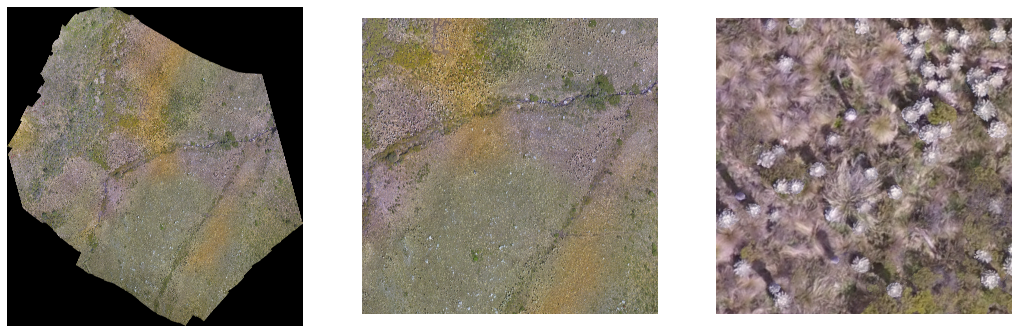

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18,6))

axs[0].imshow(full_img_og[:,:,0:3])
axs[1].imshow(full_img)
axs[2].imshow(X_train[0].reshape(512,512,4)[:,:,0:3])

# Remove axes
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

# Set equal spacing
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')



# Looking at DEM validity

Text(0.5, 1.0, 'Mask')

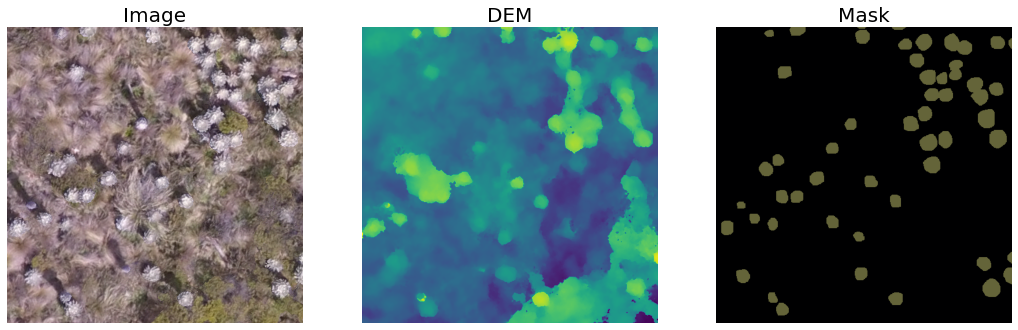

In [ ]:
sel = 0
# Show image, mask, DEM (GOOD EXAMPLE)
fig, axs = plt.subplots(1, 3, figsize=(18,6))

axs[0].imshow(X_train[sel].reshape(512,512,4)[:,:,0:3])
axs[1].imshow(X_train[sel].reshape(512,512,4)[:,:,3])
axs[2].imshow(y_train_all[sel].reshape(512,512,3))

# Remove axes
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

# Set equal spacing
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')

# Set titles
axs[0].set_title('Image', size=20)
axs[1].set_title('DEM', size=20)
axs[2].set_title('Mask', size=20)



# Models

## FCN32-VGG16

In [ ]:
def fcn_32(input_size = (512,512,3), kernel_size = 3, lr = 0.0001, drop_rate = 0, num_out=1, out_layer = 'sigmoid', lossfunc='binary_crossentropy'):
  
    kernel = kernel_size
    filter_size = 64
    pad = 1
    pool_size = 2

    IMAGE_ORDERING = 'channels_last'
    inputs = Input(shape=input_size)

    x = inputs
    levels = []

    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv1', data_format=IMAGE_ORDERING)(inputs)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    #x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',
                     #data_format=IMAGE_ORDERING)(x)

    levels.append(x)

    [f1, f2, f3, f4, f5] = levels

    o = f5

    #o = (Conv2D(512, (7 , 7 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv6"))(o)
    #o = Activation('relu')(o)
    #o = Dropout(drop_rate)(o)
    #o = (Conv2D(4096, (1 , 1 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv7"))(o)
    #o = Activation('relu')(o)
    #o = Dropout(drop_rate)(o)

    o = (Conv2D(num_out, 1, padding='same', kernel_initializer='he_normal', name="scorer1"))(o)
    o = Conv2DTranspose(num_out, kernel_size=(32,32), padding='same', strides=(16,16), name="Upsample32")(o)


    #o = Conv2D(1,1,1)(o)
    o = Activation(out_layer)(o)

    model = Model(inputs, o)
    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = lossfunc, metrics = ['accuracy', 'mse'])
    model.model_name = "fcn_32"
    return model

In [ ]:
fcn_32().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 512, 512, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 512, 512, 64)      0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856 

## U-Net

In [ ]:
def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input) 
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
def UNet(trained_weights = None, input_size = (512,512,3), kernel = 3, drop_rate = 0.25, lr=0.0001, num_out=1, out_layer = 'sigmoid', lossfunc = 'binary_crossentropy'):

    # Code modified from https://github.com/zhixuhao/unet
    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    # Hidden layers
    ## Contraction phase
    conv1 = convBlock(inputs, 64, kernel)
    conv1 = convBlock(conv1, 64, kernel)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, kernel)
    conv2 = convBlock(conv2, 128, kernel)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, kernel)
    conv3 = convBlock(conv3, 256, kernel)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, kernel)
    conv4 = convBlock(conv4, 512, kernel)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, kernel)
    conv5 = convBlock(conv5, 1024, kernel)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    #up6 = (UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, kernel)
    conv6 = convBlock(conv6, 512, kernel)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    #up7 = (UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, kernel)
    conv7 = convBlock(conv7, 256, kernel)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    #up8 = (UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, kernel)
    conv8 = convBlock(conv8, 128, kernel)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    #up9 = (UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, kernel)
    conv9 = convBlock(conv9, 64, kernel)
    conv10 = convBlock(conv9, num_out, 1, act=out_layer)


    model = Model(inputs, conv10)

    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = lossfunc, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [ ]:
UNet().summary()

## Attention U-Net

In [ ]:
def DiceBCELoss(targets, inputs, smooth=1e-6):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = tf.cast(inputs, tf.float32)
    targets = tf.cast(targets, tf.float32)
    
    BCE =  binary_crossentropy(targets, inputs)
    intersection = K.sum(targets * inputs)   
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

def DiceLoss(targets, inputs, smooth=1e-6):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = tf.cast(inputs, tf.float32)
    targets = tf.cast(targets, tf.float32)
    
    intersection = K.sum(targets * inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
def spatial_attention(x):

  avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(x)
  max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(x)

  concat = concatenate([avg_pool, max_pool], axis=3)

  #out = convBlock(concat, 2, 2, act='sigmoid')
  out = Conv2D(1, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = 'he_normal')(concat)
  out = Activation('sigmoid')(out)

  out = multiply([x, out])

  return out


def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    # Initial gate
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y


def UNetAM(trained_weights = None, input_size = (512,512,3), kernel = 3, drop_rate = 0.25, lr=0.0001, out_layer = 'sigmoid', lossfunc = 'binary_crossentropy', filter_base=16, num_out=1):

    # Code modified from https://github.com/zhixuhao/unet
    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    # Hidden layers
    ## Contraction phase
    conv = convBlock2(inputs, filter_base, kernel)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, kernel)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, kernel)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, kernel)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, kernel)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    #up4 = (UpSampling2D(size = (2,2))(conv3))
    #up4 = convBlock(up4, 8 * filter_base, kernel=3)
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, kernel)

    #up5 = (UpSampling2D(size = (2,2))(conv4))
    #up5 = convBlock(up5, 4 * filter_base, kernel=3)
    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, kernel)

    #up6 = (UpSampling2D(size = (2,2))(conv5))
    #up6 = convBlock(up6, 2 * filter_base, kernel=3)
    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, kernel)

    #up7 = (UpSampling2D(size = (2,2))(conv6))
    #up7 = convBlock(up7, 1 * filter_base, kernel=3)
    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = convBlock2(conv7, 1 * filter_base, kernel)

    out = convBlock(conv7, num_out, 1, act=out_layer)

    model = Model(inputs, out)

    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = lossfunc, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [ ]:
UNetAM().summary()

## ResUNet

Forked from: https://github.com/dmolony3/ResUNet/blob/master/res_unet.py

In [ ]:
import tensorflow as tf

def res_block_initial(x, num_filters, kernel_size, strides, name):
    """Residual Unet block layer for first layer
    In the residual unet the first residual block does not contain an
    initial batch normalization and activation so we create this separate
    block for it.
    Args:
        x: tensor, image or image activation
        num_filters: list, contains the number of filters for each subblock
        kernel_size: int, size of the convolutional kernel
        strides: list, contains the stride for each subblock convolution
        name: name of the layer
    Returns:
        x1: tensor, output from residual connection of x and x1
    """

    if len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]
            
    x1 = tf.keras.layers.Conv2D(filters=num_filters[0], 
                                kernel_size=kernel_size, 
                                strides=strides[0], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_1')(x)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[1], 
                                kernel_size=kernel_size,
                                strides=strides[1], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_2')(x1)
    
    x = tf.keras.layers.Conv2D(filters=num_filters[-1],
                                kernel_size=1,
                                strides=1,
                                padding='same',
                                kernel_initializer = 'he_normal',
                                name=name+'_shortcut')(x)
    x = tf.keras.layers.BatchNormalization()(x)
     
    x1 = tf.keras.layers.Add()([x, x1])
    
    return x1

def res_block(x, num_filters, kernel_size, strides, name):
    """Residual Unet block layer
    Consists of batch norm and relu, folowed by conv, batch norm and relu and 
    final convolution. The input is then put through 
    Args:
        x: tensor, image or image activation
        num_filters: list, contains the number of filters for each subblock
        kernel_size: int, size of the convolutional kernel
        strides: list, contains the stride for each subblock convolution
        name: name of the layer
    Returns:
        x1: tensor, output from residual connection of x and x1
    """

    if len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]

    x1 = tf.keras.layers.BatchNormalization()(x)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[0], 
                                kernel_size=kernel_size, 
                                strides=strides[0], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_1')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[1], 
                                kernel_size=kernel_size,
                                strides=strides[1], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_2')(x1)
  
    x = tf.keras.layers.Conv2D(filters=num_filters[-1],
                                    kernel_size=1,
                                    strides=strides[0],
                                    padding='same',
                                    kernel_initializer = 'he_normal',
                                    name=name+'_shortcut')(x)
    x = tf.keras.layers.BatchNormalization()(x)
                                                              
    x1 = tf.keras.layers.Add()([x, x1])

    return x1


def upsample(x, target_size):
    """"Upsampling function, upsamples the feature map
    Deep Residual Unet paper does not describe the upsampling function 
    in detail. Original Unet uses a transpose convolution that downsamples 
    the number of feature maps. In order to restrict the number of 
    parameters here we use a bilinear resampling layer. This results in 
    the concatentation layer concatenting feature maps with n and n/2 
    features as opposed to n/2  and n/2 in the original unet.
    Args:
        x: tensor, feature map
        target_size: size to resize feature map to
    Returns:
        x_resized: tensor, upsampled feature map
    """

    x_resized = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, target_size))(x)

    return x_resized
        
def encoder(x, num_filters, kernel_size):
    """Unet encoder
    Args:
        x: tensor, output from previous layer
        num_filters: list, number of filters for each decoder layer
        kernel_size: int, size of the convolutional kernel
    Returns:
        encoder_output: list, output from all encoder layers
    """

    x = res_block_initial(x, [num_filters[0]], kernel_size, strides=[1,1], name='layer1')

    encoder_output = [x]
    for i in range(1, len(num_filters)):
        layer = 'encoder_layer' + str(i)
        x = res_block(x, [num_filters[i]], kernel_size, strides=[2,1], name=layer)
        encoder_output.append(x)

    return encoder_output

def decoder(x, encoder_output, num_filters, kernel_size):
    """Unet decoder
    Args:
        x: tensor, output from previous layer
        encoder_output: list, output from all previous encoder layers
        num_filters: list, number of filters for each decoder layer
        kernel_size: int, size of the convolutional kernel
    Returns:
        x: tensor, output from last layer of decoder
    """

    for i in range(1, len(num_filters) + 1):
        layer = 'decoder_layer' + str(i)
        target_size = encoder_output[-i].shape[1:3]
        x = upsample(x, target_size)
        x = tf.keras.layers.Concatenate(axis=-1)([x, encoder_output[-i]])
        x = res_block(x, [num_filters[-i]], kernel_size, strides=[1,1], name=layer)

    return x


def res_unet(input_size, num_filters, kernel_size, num_channels, num_classes, lr = 0.0001, out_layer = 'sigmoid', lossfunc='binary_crossentropy', num_out=1):
    """Residual Unet
    Function that generates a residual unet
    Args:
        input_size: int, dimension of the input image
        num_layers: int, number of layers in the encoder half, excludes bridge
        num_filters: list, number of filters for each encoder layer
        kernel_size: size of the kernel, applied to all convolutions
        num_channels: int, number of channels for the input image
        num_classes: int, number of output classes for the output
    Returns:
        model: tensorflow keras model for residual unet architecture
    """

    x = tf.keras.Input(shape=[input_size, input_size, num_channels])

    encoder_output = encoder(x, num_filters, kernel_size)

    # bridge layer, number of filters is double that of the last encoder layer
    bridge = res_block(encoder_output[-1], [num_filters[-1]*2], kernel_size, 
                        strides=[2,1], name='bridge')

    decoder_output = decoder(bridge, encoder_output, num_filters, kernel_size)

    output = tf.keras.layers.Conv2D(num_classes, 
                                    kernel_size, 
                                    strides=1, 
                                    padding='same', 
                                    kernel_initializer = 'he_normal',
                                    name='output')(decoder_output)

    output = Activation(out_layer)(output)

    model = tf.keras.Model(x, output)
    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = lossfunc, metrics=['accuracy', 'mse'])

    return model

In [ ]:
res_unet(512, [64, 128, 256, 512], 3, 3, 1).summary()

## Attention ResUNet

In [ ]:

def attention_block2(x, gating, inter_shape, drop_rate=0.25):
   
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    # Initial gate
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = Conv2D(shape_x[3], 1, 1, kernel_initializer='he_normal')(upsample_psi)
    #upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y

def decoder2(x, encoder_output, num_filters, kernel_size):
    for i in range(1, len(num_filters) + 1):
        layer = 'decoder_layer' + str(i)
        target_size = encoder_output[-i].shape[1:3]
        # Attention Block/Mechanism
        att = attention_block2(encoder_output[-i], x, num_filters[-i], drop_rate=0.0)
        x = upsample(x, target_size)
        x = tf.keras.layers.Concatenate(axis=-1)([x, att])
        x = res_block(x, [num_filters[-i]], kernel_size, strides=[1,1], name=layer)

    return x


def att_res_unet(input_size, num_filters, kernel_size, num_channels, num_classes, lr = 0.0001, out_layer = 'sigmoid', lossfunc='binary_crossentropy', num_out=1):

    x = tf.keras.Input(shape=[input_size, input_size, num_channels])
    # Encoding
    encoder_output = encoder(x, num_filters, kernel_size)
    # Bottleneck
    bridge = res_block(encoder_output[-1], [num_filters[-1]*2], kernel_size, 
                        strides=[2,1], name='bridge')
    # Decoding
    decoder_output = decoder2(bridge, encoder_output, num_filters, kernel_size)
    # Output
    output = tf.keras.layers.Conv2D(num_classes, 
                                    kernel_size, 
                                    strides=1, 
                                    padding='same',
                                    kernel_initializer = 'he_normal', 
                                    name='output')(decoder_output)

    output = Activation(out_layer)(output)

    model = tf.keras.Model(x, output)
    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = lossfunc, metrics=['accuracy', 'mse'])

    return model

In [ ]:
att_res_unet(512, [64, 128, 256, 512], 3, 3, 1).summary()

# Train models on images for short and tall plants

## FCN32-VGG16

In [ ]:
# Train FCN32 with images
model_fcn32_kernel3 = fcn_32(input_size=(512,512,3), kernel_size = 3, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_fcn32_all = ModelCheckpoint('paramo-fcn32-kernel3.hdf5', monitor='val_accuracy',verbose=2, save_best_only=True)

model_fcn32_kernel3.fit(train_df_all, epochs=30, validation_data = validation_df_all, callbacks=[save_model_fcn32_all])



In [ ]:
# Train FCN32 with images + DEM
model_fcn32_dem_kernel3 = fcn_32(input_size=(512,512,4), kernel_size = 3, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_fcn32_dem_all = ModelCheckpoint('paramo-fcn32-dem-kernel3.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_fcn32_dem_kernel3.fit(train_dems_all_df, epochs=30, validation_data = validation_dems_all_df, callbacks=[save_model_fcn32_dem_all])

## U-Net

In [ ]:
# Train U-Net with images
model_unet_kernel3 = UNet(input_size=(512,512,3), kernel = 3, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_unet_all = ModelCheckpoint('paramo-unet-kernel3.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_unet_kernel3.fit(train_df_all, epochs=30, validation_data = validation_df_all, callbacks=[save_model_unet_all])



In [ ]:
# Train U-Net with images + DEM
model_unet_dem_kernel3 = UNet(input_size=(512,512,4), kernel = 3, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_unet_dem_all = ModelCheckpoint('paramo-unet-dem-kernel3.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_unet_dem_kernel3.fit(train_dems_all_df, epochs=30, validation_data = validation_dems_all_df, callbacks=[save_model_unet_dem_all])

## Attention U-Net

In [ ]:
# Train Attention U-Net with images
model_attention_unet_kernel3 = UNetAM(input_size=(512,512,3), kernel = 3, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_attention_unet_all = ModelCheckpoint('paramo-attention-unet-kernel3.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_attention_unet_kernel3.fit(train_df_all, epochs=30, validation_data = validation_df_all, callbacks=[save_model_attention_unet_all])



In [ ]:
# Train Attention U-Net with images + DEM
model_attention_unet_dem_kernel3 = UNet(input_size=(512,512,4), kernel = 3, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_attention_unet_dem_all = ModelCheckpoint('paramo-attention-unet-dem-kernel3.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_attention_unet_dem_kernel3.fit(train_dems_all_df, epochs=30, validation_data = validation_dems_all_df, callbacks=[save_model_attention_unet_dem_all])

## ResUNet

In [ ]:
# Train ResUNet with images
model_resunet_kernel3 = res_unet(512, [64, 128, 256, 512], kernel_size = 3, num_channels = 3, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy',lr = 0.0001)
save_model_resunet_all = ModelCheckpoint('paramo-resunet-kernel3.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resunet_kernel3.fit(train_df_all, epochs=30, validation_data = validation_df_all, callbacks=[save_model_resunet_all])



In [ ]:
# Train ResUnet with images + DEM
model_resunet_dem_kernel3 = res_unet(512, [64, 128, 256, 512], kernel_size = 3, num_channels = 4, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy',lr = 0.0001)
save_model_resunet_dem_all = ModelCheckpoint('paramo-resunet-dem-kernel3.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resunet_dem_kernel3.fit(train_dems_all_df, epochs=30, validation_data = validation_dems_all_df, callbacks=[save_model_resunet_dem_all])

## Attention ResUNet

In [ ]:
# Train Attention ResUNet with images
model_resaunet_kernel3 = att_res_unet(512, [64, 128, 256, 512], kernel_size = 3, num_channels = 3, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy', lr = 0.0001)
save_model_resaunet_all = ModelCheckpoint('paramo-resaunet-kernel3.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resaunet_kernel3.fit(train_df_all, epochs=30, validation_data = validation_df_all, callbacks=[save_model_resaunet_all])



In [ ]:
# Train Attention ResUnet with images + DEM
model_resaunet_dem_kernel3 = res_unet(512, [64, 128, 256, 512], kernel_size = 3, num_channels = 4, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy', lr = 0.0001)
save_model_resaunet_dem_all = ModelCheckpoint('paramo-resaunet-dem-kernel3.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resaunet_dem_kernel3.fit(train_dems_all_df, epochs=30, validation_data = validation_dems_all_df, callbacks=[save_model_resaunet_dem_all])

## Save models to Drive

In [ ]:
!cp paramo-unet-kernel3.hdf5 drive/MyDrive/
!cp paramo-attention-unet-kernel3.hdf5 drive/MyDrive/
!cp paramo-fcn32-kernel3.hdf5 drive/MyDrive/
!cp paramo-resunet-kernel3.hdf5 drive/MyDrive/
!cp paramo-resaunet-kernel3.hdf5 drive/MyDrive/

!cp paramo-unet-dem-kernel3.hdf5 drive/MyDrive/
!cp paramo-attention-unet-dem-kernel3.hdf5 drive/MyDrive/
!cp paramo-fcn32-dem-kernel3.hdf5 drive/MyDrive/
!cp paramo-resunet-dem-kernel3.hdf5 drive/MyDrive/
!cp paramo-resaunet-dem-kernel3.hdf5 drive/MyDrive/

# Plots

In [ ]:
fcn32_kernel3_loss = model_fcn32_kernel3.history.history['loss']
unet_kernel3_loss = model_unet_kernel3.history.history['loss']
attention_unet_kernel3_loss = model_attention_unet_kernel3.history.history['loss']
resunet_kernel3_loss = model_resunet_kernel3.history.history['loss']
resaunet_kernel3_loss = model_resaunet_kernel3.history.history['loss']

fcn32_kernel3_acc = model_fcn32_kernel3.history.history['accuracy']
unet_kernel3_acc = model_unet_kernel3.history.history['accuracy']
attention_unet_kernel3_acc = model_attention_unet_kernel3.history.history['accuracy']
resunet_kernel3_acc = model_resunet_kernel3.history.history['accuracy']
resaunet_kernel3_acc = model_resaunet_kernel3.history.history['accuracy']

fcn32_kernel3_val_acc = model_fcn32_kernel3.history.history['val_accuracy']
unet_kernel3_val_acc = model_unet_kernel3.history.history['val_accuracy']
attention_unet_kernel3_val_acc = model_attention_unet_kernel3.history.history['val_accuracy']
resunet_kernel3_val_acc = model_resunet_kernel3.history.history['val_accuracy']
resaunet_kernel3_val_acc = model_resaunet_kernel3.history.history['val_accuracy']

fcn32_dem_kernel3_loss = model_fcn32_dem_kernel3.history.history['loss']
unet_dem_kernel3_loss = model_unet_dem_kernel3.history.history['loss']
attention_unet_dem_kernel3_loss = model_attention_unet_dem_kernel3.history.history['loss']
resunet_dem_kernel3_loss = model_resunet_dem_kernel3.history.history['loss']
resaunet_dem_kernel3_loss = model_resaunet_dem_kernel3.history.history['loss']

fcn32_dem_kernel3_acc = model_fcn32_dem_kernel3.history.history['accuracy']
unet_dem_kernel3_acc = model_unet_dem_kernel3.history.history['accuracy']
attention_unet_dem_kernel3_acc = model_attention_unet_dem_kernel3.history.history['accuracy']
resunet_dem_kernel3_acc = model_resunet_dem_kernel3.history.history['accuracy']
resaunet_dem_kernel3_acc = model_resaunet_dem_kernel3.history.history['accuracy']

fcn32_dem_kernel3_val_acc = model_fcn32_dem_kernel3.history.history['val_accuracy']
unet_dem_kernel3_val_acc = model_unet_dem_kernel3.history.history['val_accuracy']
attention_unet_dem_kernel3_val_acc = model_attention_unet_dem_kernel3.history.history['val_accuracy']
resunet_dem_kernel3_val_acc = model_resunet_dem_kernel3.history.history['val_accuracy']
resaunet_dem_kernel3_val_acc = model_resaunet_dem_kernel3.history.history['val_accuracy']

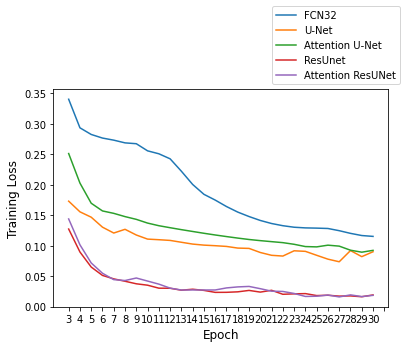

In [ ]:
plt.plot(model_fcn32_kernel3.history.history['loss'][2:])
plt.plot(model_unet_kernel3.history.history['loss'][2:])
plt.plot(model_attention_unet_kernel3.history.history['loss'][2:])
plt.plot(model_resunet_kernel3.history.history['loss'][2:])
plt.plot(model_resaunet_kernel3.history.history['loss'][2:])
'''plt.plot(fcn32_kernel3_loss[2:])
plt.plot(unet_kernel3_loss['loss'][2:])
plt.plot(attention_unet_kernel3_loss[2:])
plt.plot(resunet_kernel3_loss[2:])
plt.plot(resaunet_kernel3_loss[2:])'''
plt.ylabel('Training Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(range(0,29),range(3,31))
plt.legend(['FCN32', 'U-Net', 'Attention U-Net', 'ResUnet', 'Attention ResUNet'], bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-loss-image.png', bbox_inches = 'tight')
plt.show()

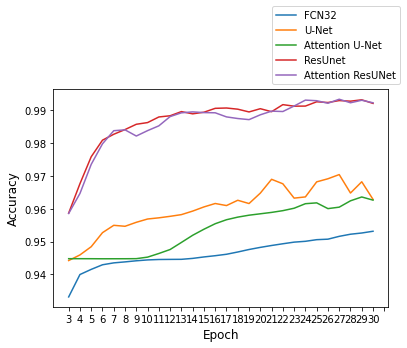

In [ ]:
plt.plot(model_fcn32_kernel3.history.history['accuracy'][2:])
plt.plot(model_unet_kernel3.history.history['accuracy'][2:])
plt.plot(model_attention_unet_kernel3.history.history['accuracy'][2:])
plt.plot(model_resunet_kernel3.history.history['accuracy'][2:])
plt.plot(model_resaunet_kernel3.history.history['accuracy'][2:])
plt.ylabel('Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(range(0,29),range(3,31))
plt.legend(['FCN32', 'U-Net', 'Attention U-Net', 'ResUnet', 'Attention ResUNet'], bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-accuracy-image.png', bbox_inches = 'tight')
plt.show()

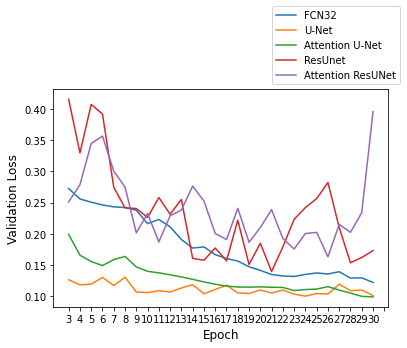

In [ ]:
plt.plot(model_fcn32_kernel3.history.history['val_loss'][2:])
plt.plot(model_unet_kernel3.history.history['val_loss'][2:])
plt.plot(model_attention_unet_kernel3.history.history['val_loss'][2:])
plt.plot(model_resunet_kernel3.history.history['val_loss'][2:])
plt.plot(model_resaunet_kernel3.history.history['val_loss'][2:])
'''plt.plot(fcn32_kernel3_loss[2:])
plt.plot(unet_kernel3_loss['loss'][2:])
plt.plot(attention_unet_kernel3_loss[2:])
plt.plot(resunet_kernel3_loss[2:])
plt.plot(resaunet_kernel3_loss[2:])'''
plt.ylabel('Validation Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(range(0,29),range(3,31))
plt.legend(['FCN32', 'U-Net', 'Attention U-Net', 'ResUnet', 'Attention ResUNet'], bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-loss-image.png', bbox_inches = 'tight')
plt.show()

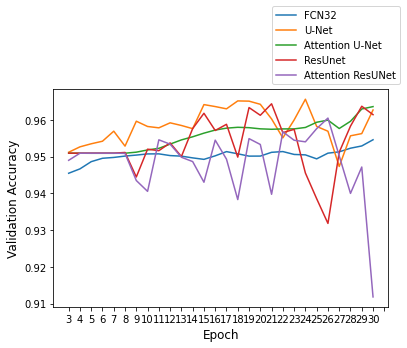

In [ ]:
plt.plot(model_fcn32_kernel3.history.history['val_accuracy'][2:])
plt.plot(model_unet_kernel3.history.history['val_accuracy'][2:])
plt.plot(model_attention_unet_kernel3.history.history['val_accuracy'][2:])
plt.plot(model_resunet_kernel3.history.history['val_accuracy'][2:])
plt.plot(model_resaunet_kernel3.history.history['val_accuracy'][2:])
plt.ylabel('Validation Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(range(0,29),range(3,31))
plt.legend(['FCN32', 'U-Net', 'Attention U-Net', 'ResUnet', 'Attention ResUNet'], bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-accuracy-image.png', bbox_inches = 'tight')
plt.show()

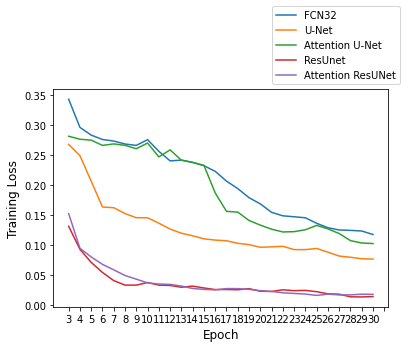

In [ ]:
plt.plot(model_fcn32_dem_kernel3.history.history['loss'][2:])
plt.plot(model_unet_dem_kernel3.history.history['loss'][2:])
plt.plot(model_attention_unet_dem_kernel3.history.history['loss'][2:])
plt.plot(model_resunet_dem_kernel3.history.history['loss'][2:])
plt.plot(model_resaunet_dem_kernel3.history.history['loss'][2:])
plt.ylabel('Training Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(range(0,29),range(3,31))
plt.legend(['FCN32', 'U-Net', 'Attention U-Net', 'ResUnet', 'Attention ResUNet'], bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-loss-image+dem.png', bbox_inches = 'tight')
plt.show()

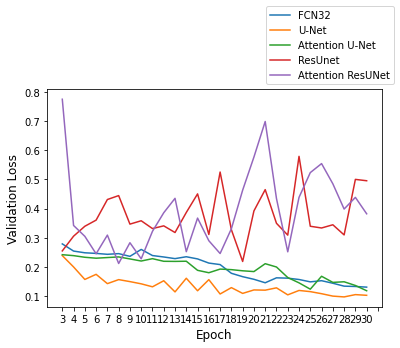

In [ ]:
plt.plot(model_fcn32_dem_kernel3.history.history['val_loss'][2:])
plt.plot(model_unet_dem_kernel3.history.history['val_loss'][2:])
plt.plot(model_attention_unet_dem_kernel3.history.history['val_loss'][2:])
plt.plot(model_resunet_dem_kernel3.history.history['val_loss'][2:])
plt.plot(model_resaunet_dem_kernel3.history.history['val_loss'][2:])
plt.ylabel('Validation Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(range(0,29),range(3,31))
plt.legend(['FCN32', 'U-Net', 'Attention U-Net', 'ResUnet', 'Attention ResUNet'], bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-loss-image+dem.png', bbox_inches = 'tight')
plt.show()

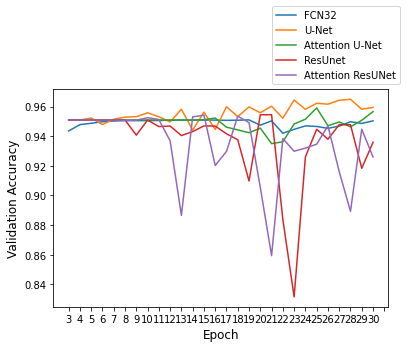

In [ ]:
plt.plot(model_fcn32_dem_kernel3.history.history['val_accuracy'][2:])
plt.plot(model_unet_dem_kernel3.history.history['val_accuracy'][2:])
plt.plot(model_attention_unet_dem_kernel3.history.history['val_accuracy'][2:])
plt.plot(model_resunet_dem_kernel3.history.history['val_accuracy'][2:])
plt.plot(model_resaunet_dem_kernel3.history.history['val_accuracy'][2:])
plt.ylabel('Validation Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(range(0,29),range(3,31))
plt.legend(['FCN32', 'U-Net', 'Attention U-Net', 'ResUnet', 'Attention ResUNet'], bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-accuracy-image+dem.png', bbox_inches = 'tight')
plt.show()

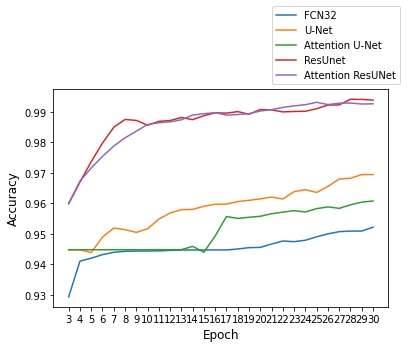

In [ ]:
plt.plot(model_fcn32_dem_kernel3.history.history['accuracy'][2:])
plt.plot(model_unet_dem_kernel3.history.history['accuracy'][2:])
plt.plot(model_attention_unet_dem_kernel3.history.history['accuracy'][2:])
plt.plot(model_resunet_dem_kernel3.history.history['accuracy'][2:])
plt.plot(model_resaunet_dem_kernel3.history.history['accuracy'][2:])
plt.ylabel('Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(range(0,29),range(3,31))
plt.legend(['FCN32', 'U-Net', 'Attention U-Net', 'ResUnet', 'Attention ResUNet'], bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-accuracy-image+dem.png', bbox_inches = 'tight')
plt.show()

# Individual training plots

## FCN32

In [ ]:
# Train FCN32 with images
model_fcn32_kernel3_0001 = fcn_32(input_size=(512,512,3), kernel_size = 3, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_fcn32_all = ModelCheckpoint('paramo-fcn32-kernel3-0001.hdf5', monitor='val_accuracy',verbose=2, save_best_only=True)

model_fcn32_kernel3_0001.fit(train_df_all, epochs=60, validation_data = validation_df_all, callbacks=[save_model_fcn32_all])

In [ ]:
model_fcn32_kernel3_0005 = fcn_32(input_size=(512,512,3), kernel_size = 3, lr = 0.0005, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_fcn32_all = ModelCheckpoint('paramo-fcn32-kernel3-0005.hdf5', monitor='val_accuracy',verbose=2, save_best_only=True)

model_fcn32_kernel3_0005.fit(train_df_all, epochs=60, validation_data = validation_df_all, callbacks=[save_model_fcn32_all])

In [ ]:
model_fcn32_kernel3_001 = fcn_32(input_size=(512,512,3), kernel_size = 3, lr = 0.001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_fcn32_all = ModelCheckpoint('paramo-fcn32-kernel3-001.hdf5', monitor='val_accuracy',verbose=2, save_best_only=True)

model_fcn32_kernel3_001.fit(train_df_all, epochs=60, validation_data = validation_df_all, callbacks=[save_model_fcn32_all])

In [ ]:
!cp paramo-fcn32-kernel3-0001.hdf5 drive/MyDrive/
!cp paramo-fcn32-kernel3-0005.hdf5 drive/MyDrive/
!cp paramo-fcn32-kernel3-001.hdf5 drive/MyDrive/

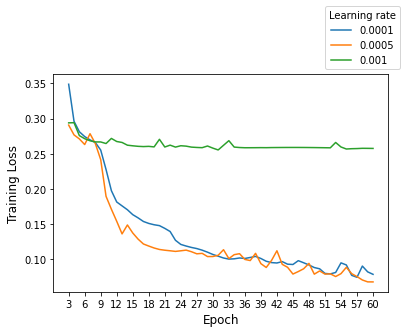

In [ ]:
plt.plot(model_fcn32_kernel3_0001.history.history['loss'][2:])
plt.plot(model_fcn32_kernel3_0005.history.history['loss'][2:])
plt.plot(model_fcn32_kernel3_001.history.history['loss'][2:])
plt.ylabel('Training Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001', '0.0005', '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-loss-fcn32-image.png', bbox_inches = 'tight')
plt.show()

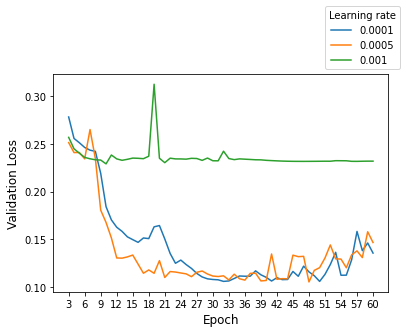

In [ ]:
plt.plot(model_fcn32_kernel3_0001.history.history['val_loss'][2:])
plt.plot(model_fcn32_kernel3_0005.history.history['val_loss'][2:])
plt.plot(model_fcn32_kernel3_001.history.history['val_loss'][2:])
plt.ylabel('Validation Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))

plt.legend(['0.0001', '0.0005', '0.001'], title = 'Learning rate',bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-loss-fcn32-image.png', bbox_inches = 'tight')
plt.show()

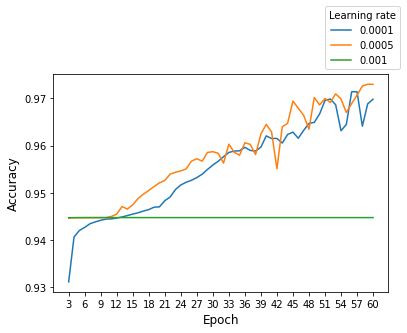

In [ ]:
plt.plot(model_fcn32_kernel3_0001.history.history['accuracy'][2:])
plt.plot(model_fcn32_kernel3_0005.history.history['accuracy'][2:])
plt.plot(model_fcn32_kernel3_001.history.history['accuracy'][2:])
plt.ylabel('Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend(['0.0001', '0.0005', '0.001'],title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-accuracy-fcn32-image.png', bbox_inches = 'tight')
plt.show()

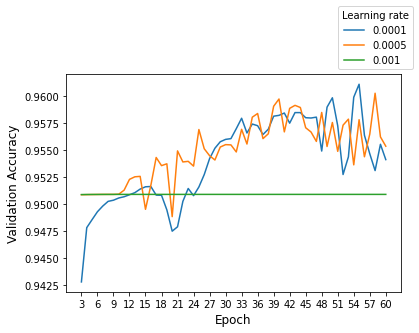

In [ ]:
plt.plot(model_fcn32_kernel3_0001.history.history['val_accuracy'][2:])
plt.plot(model_fcn32_kernel3_0005.history.history['val_accuracy'][2:])
plt.plot(model_fcn32_kernel3_001.history.history['val_accuracy'][2:])
plt.ylabel('Validation Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend(['0.0001', '0.0005', '0.001'],title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-accuracy-fcn32-image.png', bbox_inches = 'tight')
plt.show()

## UNet

In [ ]:
# Train U-Net with images
model_unet_kernel3_0001 = UNet(input_size=(512,512,3), kernel = 3, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_unet_all = ModelCheckpoint('paramo-unet-kernel3-0001.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_unet_kernel3_0001.fit(train_df_all, epochs=60, validation_data = validation_df_all, callbacks=[save_model_unet_all])

In [ ]:
# Train U-Net with images
model_unet_kernel3_0005 = UNet(input_size=(512,512,3), kernel = 3, lr = 0.0005, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_unet_all = ModelCheckpoint('paramo-unet-kernel3-0005.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_unet_kernel3_0005.fit(train_df_all, epochs=60, validation_data = validation_df_all, callbacks=[save_model_unet_all])

In [ ]:
# Train U-Net with images
model_unet_kernel3_001 = UNet(input_size=(512,512,3), kernel = 3, lr = 0.001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_unet_all = ModelCheckpoint('paramo-unet-kernel3-001.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_unet_kernel3_001.fit(train_df_all, epochs=60, validation_data = validation_df_all, callbacks=[save_model_unet_all])

In [ ]:
!cp paramo-unet-kernel3-0001.hdf5 drive/MyDrive/
!cp paramo-unet-kernel3-0005.hdf5 drive/MyDrive/
!cp paramo-unet-kernel3-001.hdf5 drive/MyDrive/

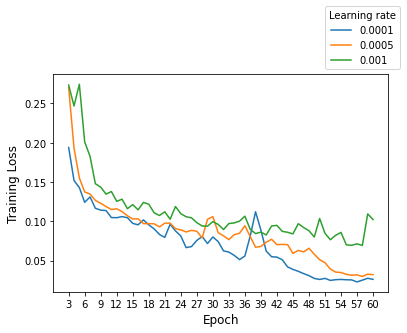

In [ ]:
plt.plot(model_unet_kernel3_0001.history.history['loss'][2:])
plt.plot(model_unet_kernel3_0005.history.history['loss'][2:])
plt.plot(model_unet_kernel3_001.history.history['loss'][2:])
plt.ylabel('Training Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001','0.0005' , '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-loss-unet-image.png', bbox_inches = 'tight')
plt.show()

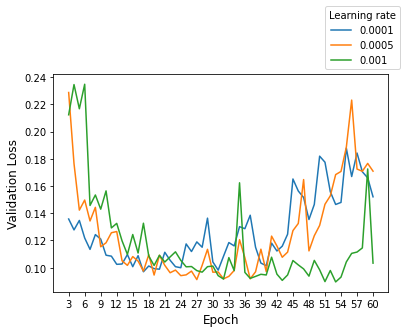

In [ ]:
plt.plot(model_unet_kernel3_0001.history.history['val_loss'][2:])
plt.plot(model_unet_kernel3_0005.history.history['val_loss'][2:])
plt.plot(model_unet_kernel3_001.history.history['val_loss'][2:])
plt.ylabel('Validation Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001','0.0005' , '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-loss-unet-image.png', bbox_inches = 'tight')
plt.show()

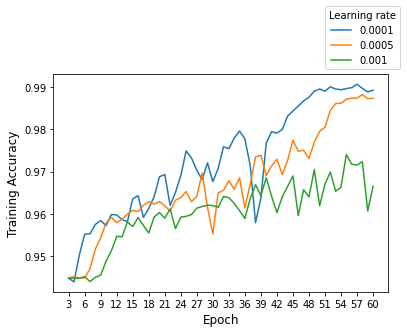

In [ ]:
plt.plot(model_unet_kernel3_0001.history.history['accuracy'][2:])
plt.plot(model_unet_kernel3_0005.history.history['accuracy'][2:])
plt.plot(model_unet_kernel3_001.history.history['accuracy'][2:])
plt.ylabel('Training Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001', '0.0005', '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-accuracy-unet-image.png', bbox_inches = 'tight')
plt.show()

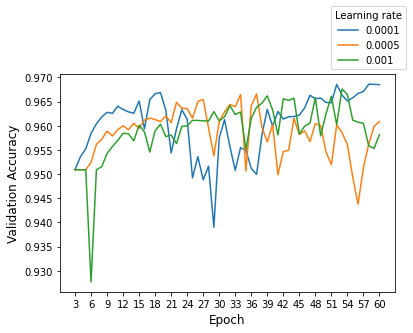

In [ ]:
plt.plot(model_unet_kernel3_0001.history.history['val_accuracy'][2:])
plt.plot(model_unet_kernel3_0005.history.history['val_accuracy'][2:])
plt.plot(model_unet_kernel3_001.history.history['val_accuracy'][2:])
plt.ylabel('Validation Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001', '0.0005', '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-accuracy-unet-image.png', bbox_inches = 'tight')
plt.show()

## Attention UNet

In [ ]:
# Train Attention U-Net with images
model_attention_unet_kernel3_0001 = UNetAM(input_size=(512,512,3), kernel = 3, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_attention_unet_all = ModelCheckpoint('paramo-attention-unet-kernel3-0001.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_attention_unet_kernel3_0001.fit(train_df_all, epochs=60, validation_data = validation_df_all, callbacks=[save_model_attention_unet_all])

In [ ]:
# Train Attention U-Net with images
model_attention_unet_kernel3_0005 = UNetAM(input_size=(512,512,3), kernel = 3, lr = 0.0005, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_attention_unet_all = ModelCheckpoint('paramo-attention-unet-kernel3-0005.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_attention_unet_kernel3_0005.fit(train_df_all, epochs=60, validation_data = validation_df_all, callbacks=[save_model_attention_unet_all])

In [ ]:
# Train Attention U-Net with images
model_attention_unet_kernel3_001 = UNetAM(input_size=(512,512,3), kernel = 3, lr = 0.001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_attention_unet_all = ModelCheckpoint('paramo-attention-unet-kernel3-001.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_attention_unet_kernel3_001.fit(train_df_all, epochs=60, validation_data = validation_df_all, callbacks=[save_model_attention_unet_all])

In [ ]:
!cp paramo-attention-unet-kernel3-0001.hdf5 drive/MyDrive/
!cp paramo-attention-unet-kernel3-0005.hdf5 drive/MyDrive/
!cp paramo-attention-unet-kernel3-001.hdf5 drive/MyDrive/

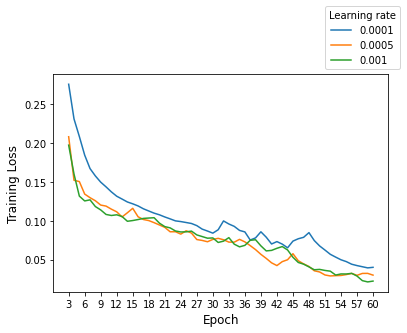

In [ ]:
plt.plot(model_attention_unet_kernel3_0001.history.history['loss'][2:])
plt.plot(model_attention_unet_kernel3_0005.history.history['loss'][2:])
plt.plot(model_attention_unet_kernel3_001.history.history['loss'][2:])
plt.ylabel('Training Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001','0.0005' , '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-loss-att-unet-image.png', bbox_inches = 'tight')
plt.show()

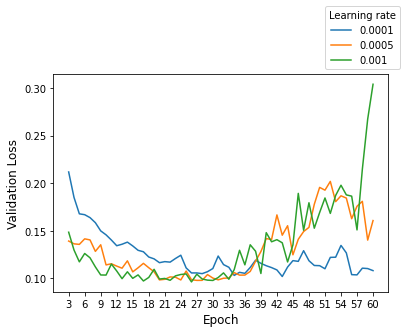

In [ ]:
plt.plot(model_attention_unet_kernel3_0001.history.history['val_loss'][2:])
plt.plot(model_attention_unet_kernel3_0005.history.history['val_loss'][2:])
plt.plot(model_attention_unet_kernel3_001.history.history['val_loss'][2:])
plt.ylabel('Validation Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001','0.0005' , '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-validation-loss-att-unet-image.png', bbox_inches = 'tight')
plt.show()

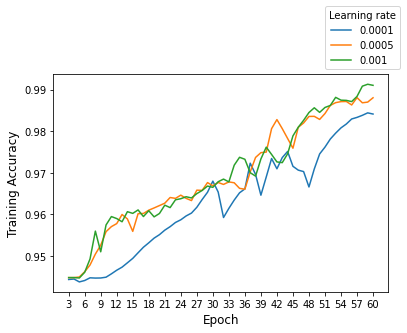

In [ ]:
plt.plot(model_attention_unet_kernel3_0001.history.history['accuracy'][2:])
plt.plot(model_attention_unet_kernel3_0005.history.history['accuracy'][2:])
plt.plot(model_attention_unet_kernel3_001.history.history['accuracy'][2:])
plt.ylabel('Training Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001','0.0005' , '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-accuracy-att-unet-image.png', bbox_inches = 'tight')
plt.show()

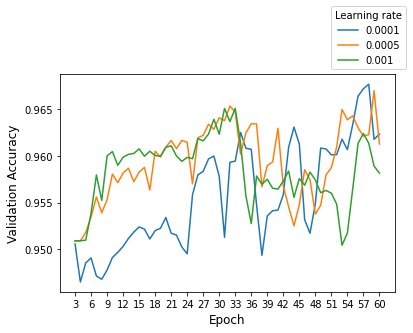

In [ ]:
plt.plot(model_attention_unet_kernel3_0001.history.history['val_accuracy'][2:])
plt.plot(model_attention_unet_kernel3_0005.history.history['val_accuracy'][2:])
plt.plot(model_attention_unet_kernel3_001.history.history['val_accuracy'][2:])
plt.ylabel('Validation Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001','0.0005' , '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-validation-accuracy-att-unet-image.png', bbox_inches = 'tight')
plt.show()

## ResUNet


In [ ]:
model_resunet_kernel3_00001 = res_unet(512, [64, 128, 256, 512], kernel_size = 3, num_channels = 3, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy',lr = 0.00001)
save_model_resunet_all = ModelCheckpoint('paramo-resunet-kernel3-00001.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resunet_kernel3_00001.fit(train_df_all, epochs=30, validation_data = validation_df_all, callbacks=[save_model_resunet_all])

In [ ]:
model_resunet_kernel3_00005 = res_unet(512, [64, 128, 256, 512], kernel_size = 3, num_channels = 3, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy',lr = 0.00005)
save_model_resunet_all = ModelCheckpoint('paramo-resunet-kernel3-00005.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resunet_kernel3_00005.fit(train_df_all, epochs=30, validation_data = validation_df_all, callbacks=[save_model_resunet_all])

In [ ]:
!cp paramo-resunet-kernel3-00001.hdf5 drive/MyDrive/
!cp paramo-resunet-kernel3-00005.hdf5 drive/MyDrive/


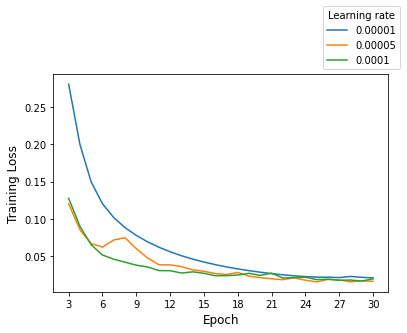

In [ ]:
plt.plot(model_resunet_kernel3_00001.history.history['loss'][2:])
plt.plot(model_resunet_kernel3_00005.history.history['loss'][2:])
plt.plot(model_resunet_kernel3.history.history['loss'][2:])
plt.ylabel('Training Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,30, 3.0),np.arange(3,31, 3))
plt.legend( ['0.00001', '0.00005', '0.0001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-loss-resunet-image.png', bbox_inches = 'tight')
plt.show()

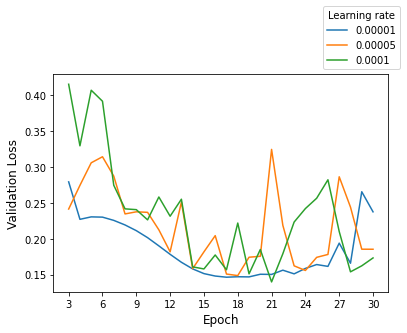

In [ ]:
plt.plot(model_resunet_kernel3_00001.history.history['val_loss'][2:])
plt.plot(model_resunet_kernel3_00005.history.history['val_loss'][2:])
plt.plot(model_resunet_kernel3.history.history['val_loss'][2:])
plt.ylabel('Validation Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,30, 3.0),np.arange(3,31, 3))
plt.legend( ['0.00001', '0.00005', '0.0001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-loss-resunet-image.png', bbox_inches = 'tight')
plt.show()

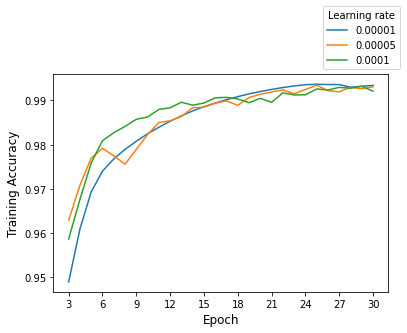

In [ ]:
plt.plot(model_resunet_kernel3_00001.history.history['accuracy'][2:])
plt.plot(model_resunet_kernel3_00005.history.history['accuracy'][2:])
plt.plot(model_resunet_kernel3.history.history['accuracy'][2:])
plt.ylabel('Training Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,30, 3.0),np.arange(3,31, 3))
plt.legend( ['0.00001', '0.00005', '0.0001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-accuracy-resunet-image.png', bbox_inches = 'tight')
plt.show()

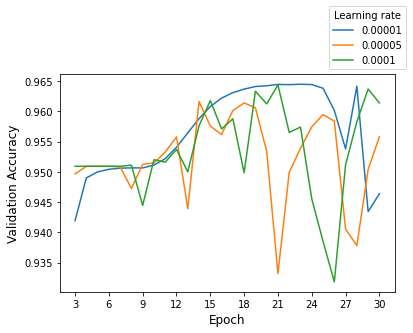

In [ ]:
plt.plot(model_resunet_kernel3_00001.history.history['val_accuracy'][2:])
plt.plot(model_resunet_kernel3_00005.history.history['val_accuracy'][2:])
plt.plot(model_resunet_kernel3.history.history['val_accuracy'][2:])
plt.ylabel('Validation Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,30, 3.0),np.arange(3,31, 3))
plt.legend( ['0.00001', '0.00005', '0.0001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-accuracy-resunet-image.png', bbox_inches = 'tight')
plt.show()

## Attention ResUNet

In [ ]:
# Train Attention ResUNet with images
model_resaunet_kernel3_00001 = att_res_unet(512, [64, 128, 256, 512], kernel_size = 3, num_channels = 3, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy', lr = 0.00001)
save_model_resaunet_all = ModelCheckpoint('paramo-resaunet-kernel3-00001.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resaunet_kernel3_00001.fit(train_df_all, epochs=30, validation_data = validation_df_all, callbacks=[save_model_resaunet_all])

In [ ]:
model_resaunet_kernel3_00005 = att_res_unet(512, [64, 128, 256, 512], kernel_size = 3, num_channels = 3, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy', lr = 0.00005)
save_model_resaunet_all = ModelCheckpoint('paramo-resaunet-kernel3-00005.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resaunet_kernel3_00005.fit(train_df_all, epochs=30, validation_data = validation_df_all, callbacks=[save_model_resaunet_all])

In [ ]:
!cp paramo-resaunet-kernel3-00001.hdf5 drive/MyDrive/
!cp paramo-resaunet-kernel3-00005.hdf5 drive/MyDrive/


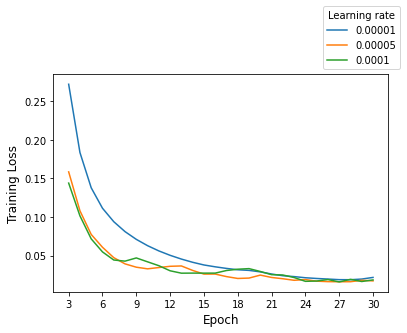

In [ ]:
plt.plot(model_resaunet_kernel3_00001.history.history['loss'][2:])
plt.plot(model_resaunet_kernel3_00005.history.history['loss'][2:])
plt.plot(model_resaunet_kernel3.history.history['loss'][2:])
plt.ylabel('Training Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,30, 3.0),np.arange(3,31, 3))
plt.legend( ['0.00001', '0.00005', '0.0001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-loss-resaunet-image.png', bbox_inches = 'tight')
plt.show()

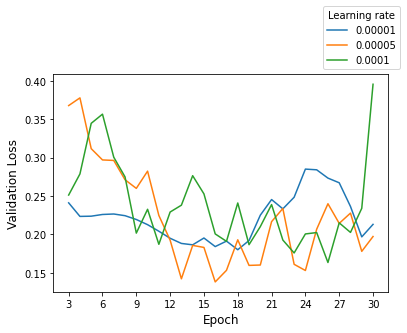

In [ ]:
plt.plot(model_resaunet_kernel3_00001.history.history['val_loss'][2:])
plt.plot(model_resaunet_kernel3_00005.history.history['val_loss'][2:])
plt.plot(model_resaunet_kernel3.history.history['val_loss'][2:])
plt.ylabel('Validation Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,30, 3.0),np.arange(3,31, 3))
plt.legend( ['0.00001', '0.00005', '0.0001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-loss-resaunet-image.png', bbox_inches = 'tight')
plt.show()

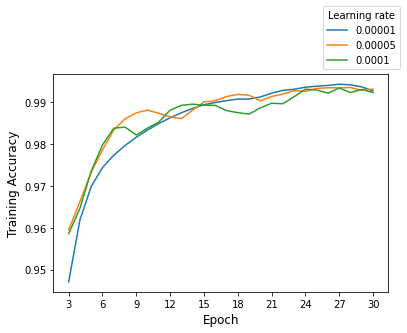

In [ ]:
plt.plot(model_resaunet_kernel3_00001.history.history['accuracy'][2:])
plt.plot(model_resaunet_kernel3_00005.history.history['accuracy'][2:])
plt.plot(model_resaunet_kernel3.history.history['accuracy'][2:])
plt.ylabel('Training Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,30, 3.0),np.arange(3,31, 3))
plt.legend( ['0.00001', '0.00005', '0.0001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-accuracy-resaunet-image.png', bbox_inches = 'tight')
plt.show()

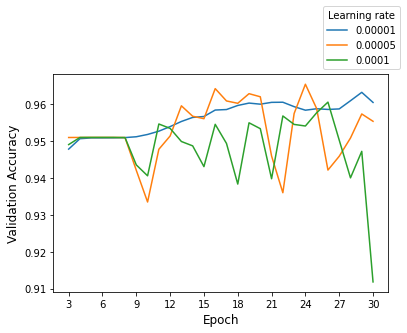

In [ ]:
plt.plot(model_resaunet_kernel3_00001.history.history['val_accuracy'][2:])
plt.plot(model_resaunet_kernel3_00005.history.history['val_accuracy'][2:])
plt.plot(model_resaunet_kernel3.history.history['val_accuracy'][2:])
plt.ylabel('Validation Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,30, 3.0),np.arange(3,31, 3))
plt.legend( ['0.00001', '0.00005', '0.0001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-accuracy-resaunet-image.png', bbox_inches = 'tight')
plt.show()

# Individual training plots (DEM)

## FCN32

In [ ]:
# Train FCN32 with images + DEM
model_fcn32_dem_kernel3_0001 = fcn_32(input_size=(512,512,4), kernel_size = 3, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_fcn32_dem_all = ModelCheckpoint('paramo-fcn32-dem-kernel3-0001.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_fcn32_dem_kernel3_0001.fit(train_dems_all_df, epochs=60, validation_data = validation_dems_all_df, callbacks=[save_model_fcn32_dem_all])

In [ ]:
model_fcn32_dem_kernel3_0005 = fcn_32(input_size=(512,512,4), kernel_size = 3, lr = 0.0005, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_fcn32_dem_all = ModelCheckpoint('paramo-fcn32-dem-kernel3-0005.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_fcn32_dem_kernel3_0005.fit(train_dems_all_df, epochs=60, validation_data = validation_dems_all_df, callbacks=[save_model_fcn32_dem_all])

In [ ]:
model_fcn32_dem_kernel3_001 = fcn_32(input_size=(512,512,4), kernel_size = 3, lr = 0.001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_fcn32_dem_all = ModelCheckpoint('paramo-fcn32-dem-kernel3-001.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_fcn32_dem_kernel3_001.fit(train_dems_all_df, epochs=60, validation_data = validation_dems_all_df, callbacks=[save_model_fcn32_dem_all])

In [ ]:
!cp paramo-fcn32-dem-kernel3-0001.hdf5 drive/MyDrive/
!cp paramo-fcn32-dem-kernel3-0005.hdf5 drive/MyDrive/
!cp paramo-fcn32-dem-kernel3-001.hdf5 drive/MyDrive/

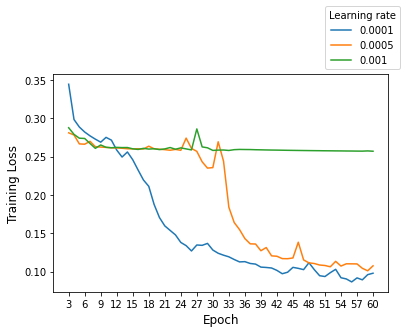

In [ ]:
plt.plot(model_fcn32_dem_kernel3_0001.history.history['loss'][2:])
plt.plot(model_fcn32_dem_kernel3_0005.history.history['loss'][2:])
plt.plot(model_fcn32_dem_kernel3_001.history.history['loss'][2:])
plt.ylabel('Training Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001', '0.0005', '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-loss-fcn32-image+dem.png', bbox_inches = 'tight')
plt.show()

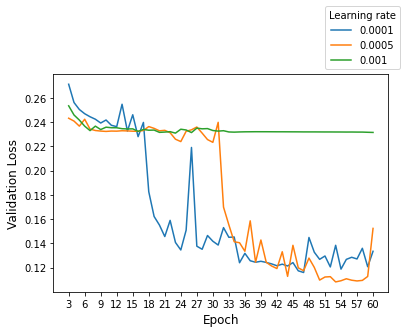

In [ ]:
plt.plot(model_fcn32_dem_kernel3_0001.history.history['val_loss'][2:])
plt.plot(model_fcn32_dem_kernel3_0005.history.history['val_loss'][2:])
plt.plot(model_fcn32_dem_kernel3_001.history.history['val_loss'][2:])
plt.ylabel('Validation Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))

plt.legend(['0.0001', '0.0005', '0.001'], title = 'Learning rate',bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-loss-fcn32-image+dem.png', bbox_inches = 'tight')
plt.show()

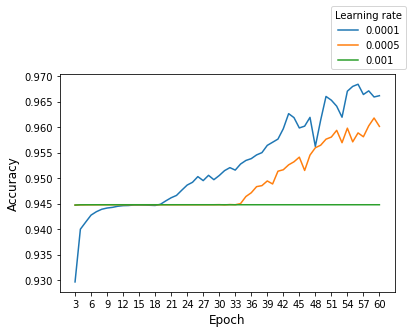

In [ ]:
plt.plot(model_fcn32_dem_kernel3_0001.history.history['accuracy'][2:])
plt.plot(model_fcn32_dem_kernel3_0005.history.history['accuracy'][2:])
plt.plot(model_fcn32_dem_kernel3_001.history.history['accuracy'][2:])
plt.ylabel('Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend(['0.0001', '0.0005', '0.001'],title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-accuracy-fcn32-image+dem.png', bbox_inches = 'tight')
plt.show()

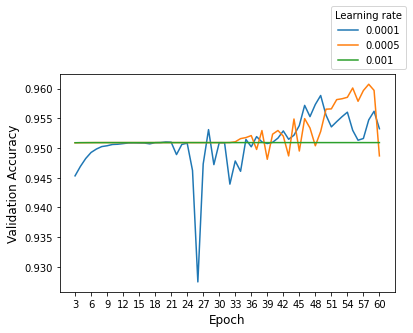

In [ ]:
plt.plot(model_fcn32_dem_kernel3_0001.history.history['val_accuracy'][2:])
plt.plot(model_fcn32_dem_kernel3_0005.history.history['val_accuracy'][2:])
plt.plot(model_fcn32_dem_kernel3_001.history.history['val_accuracy'][2:])
plt.ylabel('Validation Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend(['0.0001', '0.0005', '0.001'],title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-accuracy-fcn32-image+dem.png', bbox_inches = 'tight')
plt.show()

## UNet

In [ ]:
# Train U-Net with images + DEM
model_unet_dem_kernel3_0001 = UNet(input_size=(512,512,4), kernel = 3, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_unet_dem_all = ModelCheckpoint('paramo-unet-dem-kernel3-0001.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_unet_dem_kernel3_0001.fit(train_dems_all_df, epochs=60, validation_data = validation_dems_all_df, callbacks=[save_model_unet_dem_all])

In [ ]:
# Train U-Net with images + DEM
model_unet_dem_kernel3_0005 = UNet(input_size=(512,512,4), kernel = 3, lr = 0.0005, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_unet_dem_all = ModelCheckpoint('paramo-unet-dem-kernel3-0005.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_unet_dem_kernel3_0005.fit(train_dems_all_df, epochs=60, validation_data = validation_dems_all_df, callbacks=[save_model_unet_dem_all])

In [ ]:
# Train U-Net with images + DEM
model_unet_dem_kernel3_001 = UNet(input_size=(512,512,4), kernel = 3, lr = 0.001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_unet_dem_all = ModelCheckpoint('paramo-unet-dem-kernel3-001.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_unet_dem_kernel3_001.fit(train_dems_all_df, epochs=60, validation_data = validation_dems_all_df, callbacks=[save_model_unet_dem_all])

In [ ]:
!cp paramo-unet-dem-kernel3-0001.hdf5 drive/MyDrive/
!cp paramo-unet-dem-kernel3-0005.hdf5 drive/MyDrive/
!cp paramo-unet-dem-kernel3-001.hdf5 drive/MyDrive/

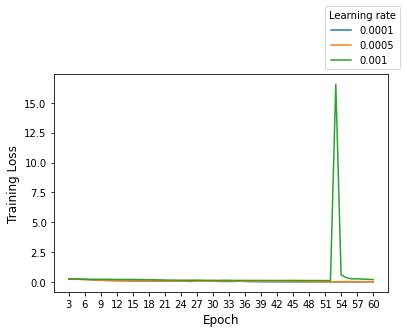

In [ ]:
plt.plot(model_unet_dem_kernel3_0001.history.history['loss'][2:])
plt.plot(model_unet_dem_kernel3_0005.history.history['loss'][2:])
plt.plot(model_unet_dem_kernel3_001.history.history['loss'][2:])
plt.ylabel('Training Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001','0.0005' , '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-loss-unet-image+dem.png', bbox_inches = 'tight')
plt.show()

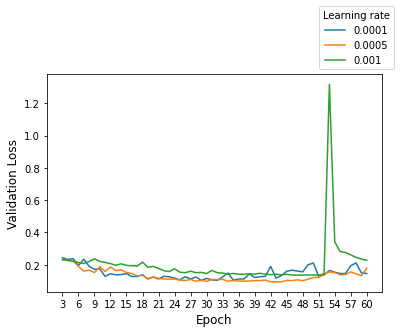

In [ ]:
plt.plot(model_unet_dem_kernel3_0001.history.history['val_loss'][2:])
plt.plot(model_unet_dem_kernel3_0005.history.history['val_loss'][2:])
plt.plot(model_unet_dem_kernel3_001.history.history['val_loss'][2:])
plt.ylabel('Validation Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001','0.0005' , '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-loss-unet-image+dem.png', bbox_inches = 'tight')
plt.show()

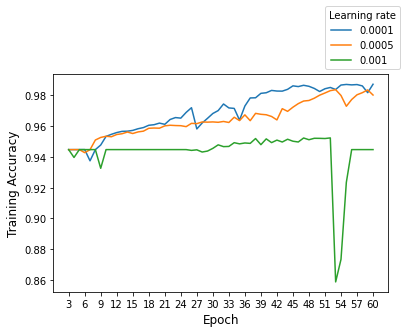

In [ ]:
plt.plot(model_unet_dem_kernel3_0001.history.history['accuracy'][2:])
plt.plot(model_unet_dem_kernel3_0005.history.history['accuracy'][2:])
plt.plot(model_unet_dem_kernel3_001.history.history['accuracy'][2:])
plt.ylabel('Training Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001', '0.0005', '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-accuracy-unet-image+dem.png', bbox_inches = 'tight')
plt.show()

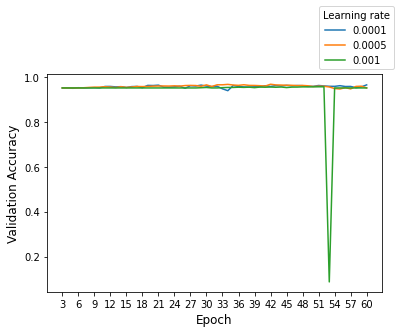

In [ ]:
plt.plot(model_unet_dem_kernel3_0001.history.history['val_accuracy'][2:])
plt.plot(model_unet_dem_kernel3_0005.history.history['val_accuracy'][2:])
plt.plot(model_unet_dem_kernel3_001.history.history['val_accuracy'][2:])
plt.ylabel('Validation Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001', '0.0005', '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-accuracy-unet-image+dem.png', bbox_inches = 'tight')
plt.show()

## Attention UNet

In [ ]:
# Train Attention U-Net with images + DEM
model_attention_unet_dem_kernel3_0001 = UNet(input_size=(512,512,4), kernel = 3, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_attention_unet_dem_all = ModelCheckpoint('paramo-attention-unet-dem-kernel3-0001.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_attention_unet_dem_kernel3_0001.fit(train_dems_all_df, epochs=60, validation_data = validation_dems_all_df, callbacks=[save_model_attention_unet_dem_all])

In [ ]:
# Train Attention U-Net with images + DEM
model_attention_unet_dem_kernel3_0005 = UNet(input_size=(512,512,4), kernel = 3, lr = 0.0005, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_attention_unet_dem_all = ModelCheckpoint('paramo-attention-unet-dem-kernel3-0005.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_attention_unet_dem_kernel3_0005.fit(train_dems_all_df, epochs=60, validation_data = validation_dems_all_df, callbacks=[save_model_attention_unet_dem_all])

In [ ]:
# Train Attention U-Net with images + DEM
model_attention_unet_dem_kernel3_001 = UNet(input_size=(512,512,4), kernel = 3, lr = 0.001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_attention_unet_dem_all = ModelCheckpoint('paramo-attention-unet-dem-kernel3-001.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_attention_unet_dem_kernel3_001.fit(train_dems_all_df, epochs=60, validation_data = validation_dems_all_df, callbacks=[save_model_attention_unet_dem_all])

In [ ]:
!cp paramo-attention-unet-dem-kernel3-0001.hdf5 drive/MyDrive/
!cp paramo-attention-unet-dem-kernel3-0005.hdf5 drive/MyDrive/
!cp paramo-attention-unet-dem-kernel3-001.hdf5 drive/MyDrive/

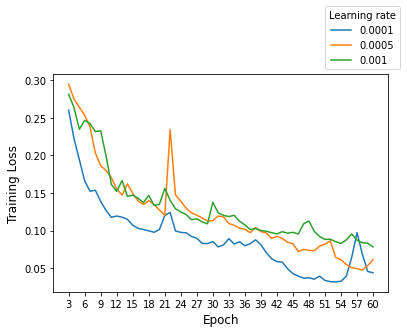

In [ ]:
plt.plot(model_attention_unet_dem_kernel3_0001.history.history['loss'][2:])
plt.plot(model_attention_unet_dem_kernel3_0005.history.history['loss'][2:])
plt.plot(model_attention_unet_dem_kernel3_001.history.history['loss'][2:])
plt.ylabel('Training Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001','0.0005' , '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-loss-att-unet-image+dem.png', bbox_inches = 'tight')
plt.show()

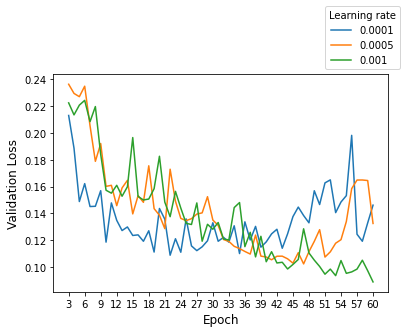

In [ ]:
plt.plot(model_attention_unet_dem_kernel3_0001.history.history['val_loss'][2:])
plt.plot(model_attention_unet_dem_kernel3_0005.history.history['val_loss'][2:])
plt.plot(model_attention_unet_dem_kernel3_001.history.history['val_loss'][2:])
plt.ylabel('Validation Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001','0.0005' , '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-validation-loss-att-unet-image+dem.png', bbox_inches = 'tight')
plt.show()

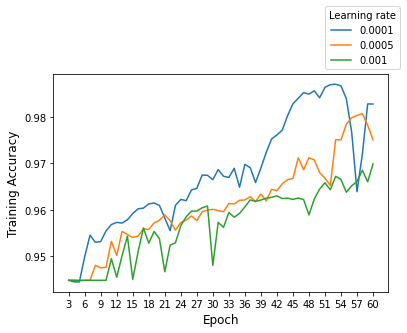

In [ ]:
plt.plot(model_attention_unet_dem_kernel3_0001.history.history['accuracy'][2:])
plt.plot(model_attention_unet_dem_kernel3_0005.history.history['accuracy'][2:])
plt.plot(model_attention_unet_dem_kernel3_001.history.history['accuracy'][2:])
plt.ylabel('Training Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001','0.0005' , '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-accuracy-att-unet-image+dem.png', bbox_inches = 'tight')
plt.show()

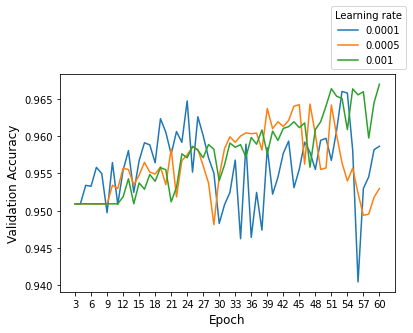

In [ ]:
plt.plot(model_attention_unet_dem_kernel3_0001.history.history['val_accuracy'][2:])
plt.plot(model_attention_unet_dem_kernel3_0005.history.history['val_accuracy'][2:])
plt.plot(model_attention_unet_dem_kernel3_001.history.history['val_accuracy'][2:])
plt.ylabel('Validation Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,60, 3.0),np.arange(3,61, 3))
plt.legend( ['0.0001','0.0005' , '0.001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-validation-accuracy-att-unet-image+dem.png', bbox_inches = 'tight')
plt.show()

## ResUNet


In [ ]:
# Train ResUnet with images + DEM
model_resunet_dem_kernel3 = res_unet(512, [64, 128, 256, 512], kernel_size = 3, num_channels = 4, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy',lr = 0.0001)
save_model_resunet_dem_all = ModelCheckpoint('paramo-resunet-dem-kernel3.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resunet_dem_kernel3.fit(train_dems_all_df, epochs=30, validation_data = validation_dems_all_df, callbacks=[save_model_resunet_dem_all])

In [ ]:
# Train ResUnet with images + DEM
model_resunet_dem_kernel3_00001 = res_unet(512, [64, 128, 256, 512], kernel_size = 3, num_channels = 4, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy',lr = 0.00001)
save_model_resunet_dem_all = ModelCheckpoint('paramo-resunet-dem-kernel3-00001.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resunet_dem_kernel3_00001.fit(train_dems_all_df, epochs=30, validation_data = validation_dems_all_df, callbacks=[save_model_resunet_dem_all])

In [ ]:
# Train ResUnet with images + DEM
model_resunet_dem_kernel3_00005 = res_unet(512, [64, 128, 256, 512], kernel_size = 3, num_channels = 4, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy',lr = 0.00005)
save_model_resunet_dem_all = ModelCheckpoint('paramo-resunet-dem-kernel3-00005.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resunet_dem_kernel3_00005.fit(train_dems_all_df, epochs=30, validation_data = validation_dems_all_df, callbacks=[save_model_resunet_dem_all])

In [ ]:
!cp paramo-resunet-dem-kernel3-00001.hdf5 drive/MyDrive/
!cp paramo-resunet-dem-kernel3-00005.hdf5 drive/MyDrive/
!cp paramo-resunet-dem-kernel3.hdf5 drive/MyDrive/

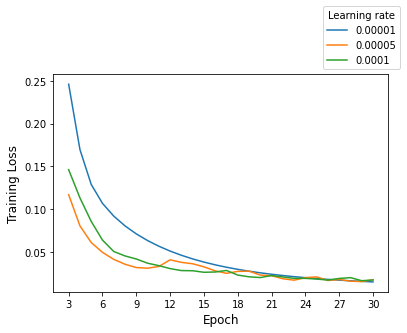

In [ ]:
plt.plot(model_resunet_dem_kernel3_00001.history.history['loss'][2:])
plt.plot(model_resunet_dem_kernel3_00005.history.history['loss'][2:])
plt.plot(model_resunet_dem_kernel3.history.history['loss'][2:])
plt.ylabel('Training Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,30, 3.0),np.arange(3,31, 3))
plt.legend( ['0.00001', '0.00005', '0.0001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-loss-resunet-image+dem.png', bbox_inches = 'tight')
plt.show()

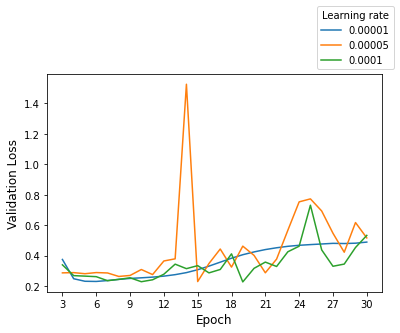

In [ ]:
plt.plot(model_resunet_dem_kernel3_00001.history.history['val_loss'][2:])
plt.plot(model_resunet_dem_kernel3_00005.history.history['val_loss'][2:])
plt.plot(model_resunet_dem_kernel3.history.history['val_loss'][2:])
plt.ylabel('Validation Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,30, 3.0),np.arange(3,31, 3))
plt.legend( ['0.00001', '0.00005', '0.0001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-loss-resunet-image+dem.png', bbox_inches = 'tight')
plt.show()

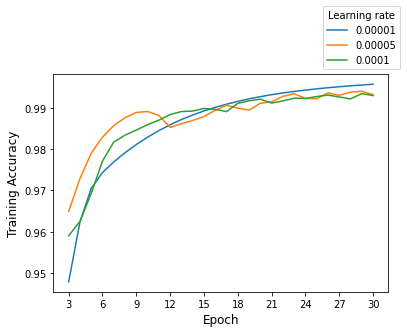

In [ ]:
plt.plot(model_resunet_dem_kernel3_00001.history.history['accuracy'][2:])
plt.plot(model_resunet_dem_kernel3_00005.history.history['accuracy'][2:])
plt.plot(model_resunet_dem_kernel3.history.history['accuracy'][2:])
plt.ylabel('Training Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,30, 3.0),np.arange(3,31, 3))
plt.legend( ['0.00001', '0.00005', '0.0001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-accuracy-resunet-image+dem.png', bbox_inches = 'tight')
plt.show()

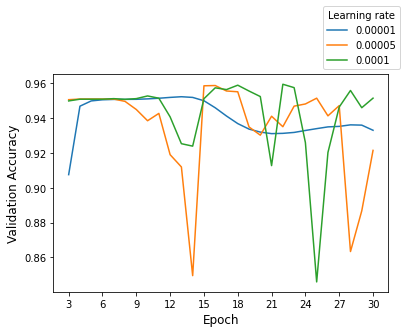

In [ ]:
plt.plot(model_resunet_dem_kernel3_00001.history.history['val_accuracy'][2:])
plt.plot(model_resunet_dem_kernel3_00005.history.history['val_accuracy'][2:])
plt.plot(model_resunet_dem_kernel3.history.history['val_accuracy'][2:])
plt.ylabel('Validation Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,30, 3.0),np.arange(3,31, 3))
plt.legend( ['0.00001', '0.00005', '0.0001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-accuracy-resunet-image+dem.png', bbox_inches = 'tight')
plt.show()

## Attention ResUNet

In [ ]:
# Train Attention ResUnet with images + DEM
model_resaunet_dem_kernel3 = res_unet(512, [64, 128, 256, 512], kernel_size = 3, num_channels = 4, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy', lr = 0.0001)
save_model_resaunet_dem_all = ModelCheckpoint('paramo-resaunet-dem-kernel3.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resaunet_dem_kernel3.fit(train_dems_all_df, epochs=30, validation_data = validation_dems_all_df, callbacks=[save_model_resaunet_dem_all])

In [ ]:
# Train Attention ResUNet with images
model_resaunet_dem_kernel3_00001 = res_unet(512, [64, 128, 256, 512], kernel_size = 3, num_channels = 4, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy', lr = 0.00001)
save_model_resaunet_dem_all = ModelCheckpoint('paramo-resaunet-dem-kernel3-00001.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resaunet_dem_kernel3_00001.fit(train_dems_all_df, epochs=30, validation_data = validation_dems_all_df, callbacks=[save_model_resaunet_dem_all])

In [ ]:
model_resaunet_dem_kernel3_00005 = res_unet(512, [64, 128, 256, 512], kernel_size = 3, num_channels = 4, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy', lr = 0.00005)
save_model_resaunet_dem_all = ModelCheckpoint('paramo-resaunet-dem-kernel3-00005.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resaunet_dem_kernel3_00005.fit(train_dems_all_df, epochs=30, validation_data = validation_dems_all_df, callbacks=[save_model_resaunet_dem_all])

In [ ]:
!cp paramo-resaunet-kernel3-00001.hdf5 drive/MyDrive/
!cp paramo-resaunet-kernel3-00005.hdf5 drive/MyDrive/
!cp paramo-resaunet-kernel3.hdf5 drive/MyDrive/


cp: cannot stat 'paramo-resaunet-kernel3-00001.hdf5': No such file or directory
cp: cannot stat 'paramo-resaunet-kernel3-00005.hdf5': No such file or directory
cp: cannot stat 'paramo-resaunet-kernel3.hdf5': No such file or directory


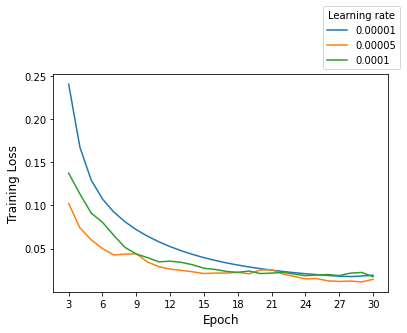

In [ ]:
plt.plot(model_resaunet_dem_kernel3_00001.history.history['loss'][2:])
plt.plot(model_resaunet_dem_kernel3_00005.history.history['loss'][2:])
plt.plot(model_resaunet_dem_kernel3.history.history['loss'][2:])
plt.ylabel('Training Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,30, 3.0),np.arange(3,31, 3))
plt.legend( ['0.00001', '0.00005', '0.0001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-loss-resaunet-image+dem.png', bbox_inches = 'tight')
plt.show()

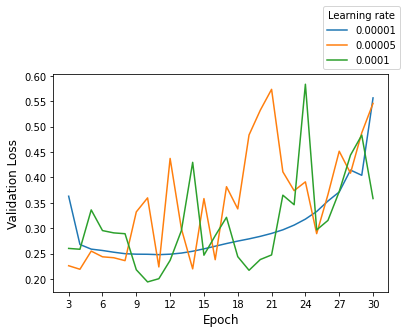

In [ ]:
plt.plot(model_resaunet_dem_kernel3_00001.history.history['val_loss'][2:])
plt.plot(model_resaunet_dem_kernel3_00005.history.history['val_loss'][2:])
plt.plot(model_resaunet_dem_kernel3.history.history['val_loss'][2:])
plt.ylabel('Validation Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,30, 3.0),np.arange(3,31, 3))
plt.legend( ['0.00001', '0.00005', '0.0001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-loss-resaunet-image+dem.png', bbox_inches = 'tight')
plt.show()

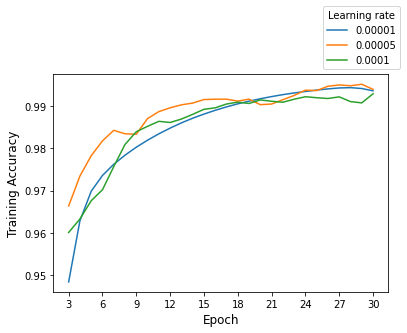

In [ ]:
plt.plot(model_resaunet_dem_kernel3_00001.history.history['accuracy'][2:])
plt.plot(model_resaunet_dem_kernel3_00005.history.history['accuracy'][2:])
plt.plot(model_resaunet_dem_kernel3.history.history['accuracy'][2:])
plt.ylabel('Training Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,30, 3.0),np.arange(3,31, 3))
plt.legend( ['0.00001', '0.00005', '0.0001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-accuracy-resaunet-image+dem.png', bbox_inches = 'tight')
plt.show()

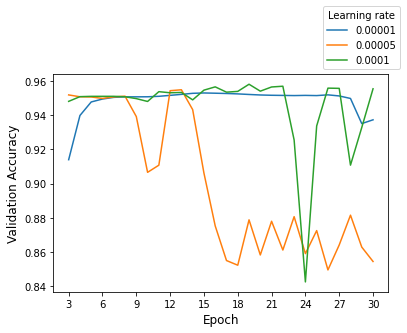

In [ ]:
plt.plot(model_resaunet_dem_kernel3_00001.history.history['val_accuracy'][2:])
plt.plot(model_resaunet_dem_kernel3_00005.history.history['val_accuracy'][2:])
plt.plot(model_resaunet_dem_kernel3.history.history['val_accuracy'][2:])
plt.ylabel('Validation Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(np.arange(0,30, 3.0),np.arange(3,31, 3))
plt.legend( ['0.00001', '0.00005', '0.0001'], title = 'Learning rate', bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-accuracy-resaunet-image+dem.png', bbox_inches = 'tight')
plt.show()

# Functions

In [ ]:
#
# Format tall and short mask reproduction correctly
#
def mask_gen(mask):
  #print(mask.shape)
  mask_out = np.zeros((512,512))
  for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
      mask_out[i,j] = np.argmax(mask[i,j,:])

  # Re-order the categories
  '''
  for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
      if mask_out[i,j] == 0:
        mask_out[i,j] = 1
      elif mask_out[i,j] == 1:
        mask_out[i,j] = 2
      else:
        mask_out[i,j] = 0
  '''
  return mask_out

In [ ]:
# Finds the most probable class for each pixel and forms an output mask of correct format (relative to the ground truth) 
def mask_from_output(ww):
  www = np.zeros(ww.shape)
  for i in range(ww.shape[0]):
    for j in range(ww.shape[1]):
      val = np.argmax(ww[i,j])
      www[i,j,val] = 1
      
  return www

In [ ]:
def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = mask_from_output(reconstruction).flatten()

    return accuracy_score(mmask_from_output(mask).flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = mask_from_output(reconstruction[0,:,:,:]).flatten()

      scores.append(accuracy_score(mask_from_output(mask[i]).flatten(), reconstruction))

    return scores

def score_eval2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = mask_gen(reconstruction).flatten()

    return accuracy_score(mask_gen(mask).flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = mask_from_output(reconstruction[0,:,:,:]).flatten()

      scores.append(accuracy_score(mask_from_output(mask[i]).flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image)#.reshape(512, 512)
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i])#.reshape(512, 512)
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image)#.reshape(512, 512)
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i])#.reshape(512, 512)
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

def jaccard_index(model, images, masks):

  preds = []
  for n in images:
    preds.append(reconstruct_array(model, n, rounded=True))

  jaccard_list = []

  # Jaccard computation
  for i in range(len(preds)):
    flat_pred = preds[i].flatten()
    flat_act =  masks[i].flatten()

    # Compute coeff (add 1 to numerator and denominator to prevent some errors)
    jaccard_list.append(jaccard_score(flat_act, flat_pred, average='weighted'))

  return np.mean(jaccard_list), np.std(jaccard_list)

def reconstruct_image(model, image, rounded=False, cmap = 'gray'):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction, cmap = cmap) 

def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

def reconstruct_array2(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2], 3)

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

def jaccard_index2(model, images, masks):

  preds = []
  for n in images:
    preds.append(reconstruct_array2(model, n, rounded=True))

  jaccard_list = []

  # Jaccard computation
  for i in range(len(preds)):
    flat_pred = preds[i].flatten()
    flat_act =  masks[i].flatten()

    # Compute coeff (add 1 to numerator and denominator to prevent some errors)
    jaccard_list.append(jaccard_score(flat_act, flat_pred, average='weighted'))

  return np.mean(jaccard_list), np.std(jaccard_list)


In [ ]:
# For multiclass evaluation
def score_eval_MULTI(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = mask_from_output(reconstruction).flatten()#np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = mask_from_output(reconstruction[0,:,:,:])#np.round(reconstruction)[0,:,:,:]

      scores.append([accuracy_score(mask[i][:,:,0].flatten(), reconstruction[:,:,0].flatten()),
                     accuracy_score(mask[i][:,:,1].flatten(), reconstruction[:,:,1].flatten()),
                     accuracy_score(mask[i][:,:,2].flatten(), reconstruction[:,:,2].flatten())])

    cl1 = 0
    cl2 = 0
    cl3 = 0
    for n in scores:
      cl1 += n[0] / len(scores)
      cl2 += n[1] / len(scores)
      cl3 += n[2] / len(scores)

    return (cl1, cl2, cl3)

def score_eval_MULTI2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = mask_gen(reconstruction).flatten()#np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = mask_gen(reconstruction[0,:,:,:])#np.round(reconstruction)[0,:,:,:]

      scores.append([accuracy_score(mask[i][:,:,0].flatten(), reconstruction[:,:,0].flatten()),
                     accuracy_score(mask[i][:,:,1].flatten(), reconstruction[:,:,1].flatten()),
                     accuracy_score(mask[i][:,:,2].flatten(), reconstruction[:,:,2].flatten())])

    cl1 = 0
    cl2 = 0
    cl3 = 0
    for n in scores:
      cl1 += n[0] / len(scores)
      cl2 += n[1] / len(scores)
      cl3 += n[2] / len(scores)

    return (cl1, cl2, cl3)

def recall_eval_MULTI(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image)#.reshape(512, 512)
    reconstruction = mask_from_output(reconstruction).flatten()#np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='samples')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i])#.reshape(512, 512)
        reconstruction = mask_from_output(reconstruction[0,:,:,:])#np.round(reconstruction)[0,:,:,:]

        recall.append([recall_score(mask[i][:,:,0].flatten(), reconstruction[:,:,0].flatten(), average='binary', zero_division=1),
                       recall_score(mask[i][:,:,1].flatten(), reconstruction[:,:,1].flatten(), average='binary', zero_division=1),
                       recall_score(mask[i][:,:,2].flatten(), reconstruction[:,:,2].flatten(), average='binary', zero_division=1)])

    cl1 = 0
    cl2 = 0
    cl3 = 0
    for n in recall:
      cl1 += n[0] / len(recall)
      cl2 += n[1] / len(recall)
      cl3 += n[2] / len(recall)

    return (cl1, cl2, cl3)

def precision_eval_MULTI(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image)#.reshape(512, 512)
    reconstruction = mask_from_output(reconstruction).flatten()#np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='samples')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i])#.reshape(512, 512)
        reconstruction = mask_from_output(reconstruction[0,:,:,:])#np.round(reconstruction)[0,:,:,:]

        precision.append([precision_score(mask[i][:,:,0].flatten(), reconstruction[:,:,0].flatten(), average='binary', zero_division=1),
                          precision_score(mask[i][:,:,1].flatten(), reconstruction[:,:,1].flatten(), average='binary', zero_division=1),
                          precision_score(mask[i][:,:,2].flatten(), reconstruction[:,:,2].flatten(), average='binary', zero_division=1)])

    cl1 = 0
    cl2 = 0
    cl3 = 0
    for n in precision:
      cl1 += n[0] / len(precision)
      cl2 += n[1] / len(precision)
      cl3 += n[2] / len(precision)

    return (cl1, cl2, cl3)

def f1_score_eval_MULTI(model, image, mask): # Find F1-score
  if type(image) != list:   
    reconstruction = model.predict(image)#.reshape(512, 512)
    reconstruction = mask_from_output(reconstruction).flatten()#np.round(reconstruction).flatten()

    return f1score(mask.flatten(), reconstruction, average='samples')

  else: # If a list of images input, find accuracy for each
    f1 = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i])#.reshape(512, 512)
        reconstruction = mask_from_output(reconstruction[0,:,:,:])#np.round(reconstruction)[0,:,:,:]

        f1.append([f1_score(mask[i][:,:,0].flatten(), reconstruction[:,:,0].flatten(), average='binary', zero_division=1),
                          f1_score(mask[i][:,:,1].flatten(), reconstruction[:,:,1].flatten(), average='binary', zero_division=1),
                          f1_score(mask[i][:,:,2].flatten(), reconstruction[:,:,2].flatten(), average='binary', zero_division=1)])

    cl1 = 0
    cl2 = 0
    cl3 = 0
    for n in f1:
      cl1 += n[0] / len(f1)
      cl2 += n[1] / len(f1)
      cl3 += n[2] / len(f1)

    return (cl1, cl2, cl3)

def f1_score_eval_basic_MULTI(precision, recall):
    prec1, prec2, prec3 = precision
    rec1, rec2, rec3 = recall

    precs = [prec1,prec2,prec3]
    recs  = [rec1,rec2,rec3]

    scores = [0,0,0]

    for i in range(len(precs)):
      if precs[i] + recs[i] == 0:
        scores[i] = 0
      else:
        scores[i] = 2 * (precs[i] * recs[i]) / (precs[i] + recs[i])

    return scores

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

def jaccard_index_MULTI(model, images, masks):

  preds = []
  for n in images:
    preds.append(mask_from_output(reconstruction[0,:,:,:]))#reconstruct_array(model, n, rounded=True))

  jaccard_list = []

  # Jaccard computation
  for i in range(len(preds)):
    flat_pred1, flat_pred2, flat_pred3 = preds[i][0], preds[i][1], preds[i][2]
    flat_act1, flat_act2, flat_act3 = masks[i][0], masks[i][1], masks[i][2]

    # Compute coeff (add 1 to numerator and denominator to prevent some errors)
    jaccard_list.append([jaccard_score(flat_act1, flat_pred1, average='binary'),
                         jaccard_score(flat_act2, flat_pred2, average='binary'),
                         jaccard_score(flat_act3, flat_pred3, average='binary')])
                        

  cl1 = 0
  cl2 = 0
  cl3 = 0
  for n in jaccard_list:
    cl1 += n[0] / len(jaccard_list)
    cl2 += n[1] / len(jaccard_list)
    cl3 += n[2] / len(jaccard_list)

  return (cl1,cl2,cl3)

def reconstruct_image(model, image, rounded=False, cmap = 'gray'):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction, cmap = cmap) 

def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

def reconstruct_array2(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2], 3)

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

def jaccard_index_MULTI2(model, images, masks):

  preds = []
  for n in images:
    preds.append(reconstruct_array2(model, n, rounded=True))

  jaccard_list = []

  # Jaccard computation
  for i in range(len(preds)):
    flat_pred1, flat_pred2, flat_pred3 = preds[i][0], preds[i][1], preds[i][2]
    flat_act1, flat_act2, flat_act3 = masks[i][0], masks[i][1], masks[i][2]

    # Compute coeff (add 1 to numerator and denominator to prevent some errors)
    jaccard_list.append([jaccard_score(flat_act1, flat_pred1, average='binary'),
                         jaccard_score(flat_act2, flat_pred2, average='binary'),
                         jaccard_score(flat_act3, flat_pred3, average='binary')])
                        

  cl1 = 0
  cl2 = 0
  cl3 = 0
  for n in jaccard_list:
    cl1 += n[0] / len(jaccard_list)
    cl2 += n[1] / len(jaccard_list)
    cl3 += n[2] / len(jaccard_list)

  return (cl1,cl2,cl3)

In [ ]:
# Outputs list of number of pixels in each type of class 
def class_quantifier(masklist):
  if type(masklist) == list:
    counter = [i for i in range(masklist[0].shape[2])] # List the same length as number of classes in Z dimension
    for n in masklist:
      # 512x512x3 or 4 image
      for i in range(n.shape[0]):
        for j in range(n.shape[1]):
          channel_vals = n[i,j]
          val = np.argmax(channel_vals)
          counter[val] += 1

    return counter

  else:
    counter = [i for i in range(masklist.shape[2])] # List the same length as number of classes in Z dimension
    # 512x512x3 or 4 image
    for i in range(masklist.shape[0]):
      for j in range(masklist.shape[1]):
        channel_vals = masklist[i,j]
        val = np.argmax(channel_vals)
        counter[val] += 1

    return counter

# Model Comparison


In [ ]:
model_fcn32_kernel3 = load_model('drive/MyDrive/paramo-fcn32-kernel3-0001.hdf5')
model_unet_kernel3 = load_model('drive/MyDrive/paramo-unet-kernel3-0001.hdf5')
model_attention_unet_kernel3 = load_model('drive/MyDrive/paramo-attention-unet-kernel3-0001.hdf5')
model_resunet_kernel3 = load_model('drive/MyDrive/paramo-resunet-kernel3-00001.hdf5')
model_resaunet_kernel3 = load_model('drive/MyDrive/paramo-resaunet-kernel3-00005.hdf5')

model_fcn32_dem_kernel3 = load_model('drive/MyDrive/paramo-fcn32-dem-kernel3-0005.hdf5')
model_unet_dem_kernel3 = load_model('drive/MyDrive/paramo-unet-dem-kernel3-0005.hdf5')
model_attention_unet_dem_kernel3 = load_model('drive/MyDrive/paramo-attention-unet-dem-kernel3-001.hdf5')
model_resunet_dem_kernel3 = load_model('drive/MyDrive/paramo-resunet-dem-kernel3-00001.hdf5')
model_resaunet_dem_kernel3 = load_model('drive/MyDrive/paramo-resaunet-dem-kernel3.hdf5')

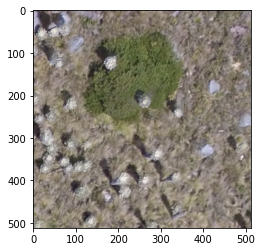

In [ ]:
# Find test image with both plants

#plt.imshow(X_test[2][:,:,0:3])
#plt.imshow(y_test_all[4][:,:,:])

u = 8


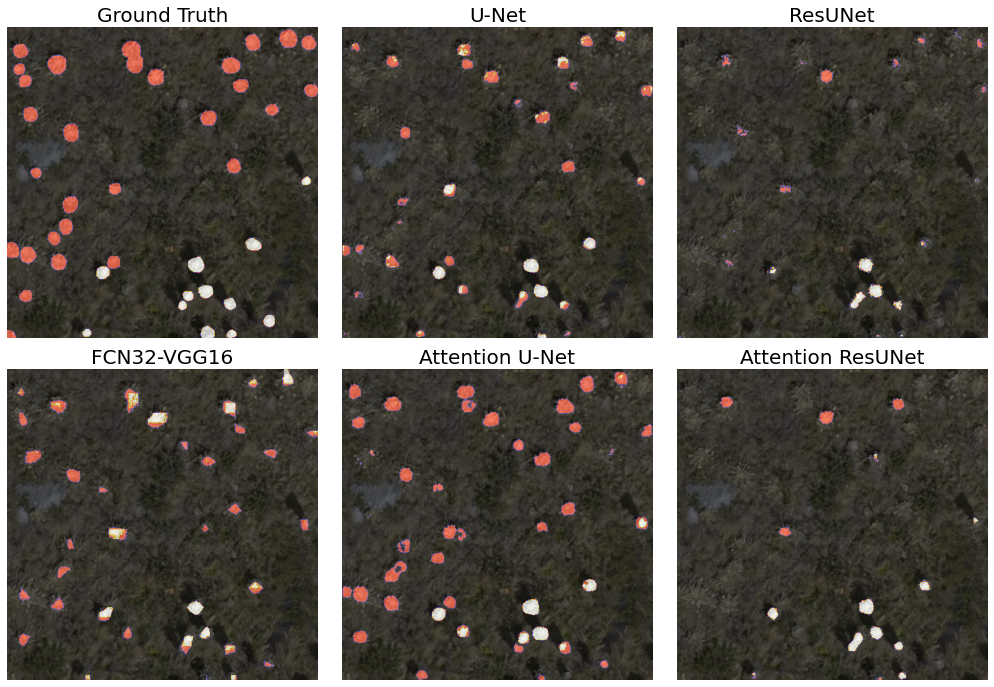

In [ ]:
# Tall and short image example
from matplotlib.patches import Circle
index = u
fig, axs = plt.subplots(2, 3, figsize=(18,12))
axs[0,0].imshow(X_test[index][:,:,0:3])
axs[0,1].imshow(X_test[index][:,:,0:3])
axs[0,2].imshow(X_test[index][:,:,0:3])
axs[1,0].imshow(X_test[index][:,:,0:3])
axs[1,1].imshow(X_test[index][:,:,0:3])
axs[1,2].imshow(X_test[index][:,:,0:3])


axs[0,0].imshow(X_test[index][:,:,0:3])
#axs[1,0].imshow(y_test_all[index][:,:,0]+2*y_test_all[index][:,:,1])

z      = model_unet_dem_kernel3.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)
zz     = model_attention_unet_dem_kernel3.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)
zzz    = model_fcn32_dem_kernel3.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)
zzzz   = model_resunet_dem_kernel3.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)
zzzzz  = model_resaunet_dem_kernel3.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)

axs[0,1].imshow(mask_gen(z), cmap='CMRmap_r', alpha=0.6)
axs[1,1].imshow(mask_gen(zz), cmap='CMRmap_r', alpha=0.6)
axs[1,0].imshow(mask_gen(zzz), cmap='CMRmap_r', alpha=0.6)
axs[0,2].imshow(mask_gen(zzzz), cmap='CMRmap_r', alpha=0.6)
axs[1,2].imshow(mask_gen(zzzzz), cmap='CMRmap_r', alpha=0.6)
axs[0,0].imshow(mask_gen(y_test_all[index]), cmap='CMRmap_r', alpha=0.6)

#axs[0,1].imshow(np.round(z), cmap='gray', alpha=0.5)
#axs[1,1].imshow(np.round(zz), cmap='gray', alpha=0.5)
#axs[1,0].imshow(np.round(zzz), cmap='gray', alpha=0.5)
#axs[0,2].imshow(np.round(zzzz), cmap='gray', alpha=0.5)
#axs[1,2].imshow(np.round(zzzzz), cmap='gray', alpha=0.5)


#circle1 = Circle((160, 160), 60, fill=False, linewidth=4, alpha=0.5, color='red')
#circle2 = Circle((320, 170), 60, fill=False, linewidth=4, alpha=0.5, color='red')
#axs[5].add_artist(circle1)
#axs[5].add_artist(circle2)

# Remove axes
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')

axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')


# Set equal spacing
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')
axs[0,2].set_aspect('equal')

axs[1,0].set_aspect('equal')
axs[1,1].set_aspect('equal')
axs[1,2].set_aspect('equal')


# Set titles
axs[0,0].set_title('Ground Truth', size=20)
axs[1,0].set_title('FCN32-VGG16', size=20)
axs[0,1].set_title('U-Net', size=20)
axs[1,1].set_title('Attention U-Net', size=20)
axs[0,2].set_title('ResUNet', size=20)
axs[1,2].set_title('Attention ResUNet', size=20)


#fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig('tallshort-dem-comparison.png', bbox_inches = 'tight', pad_inches = 0.1)

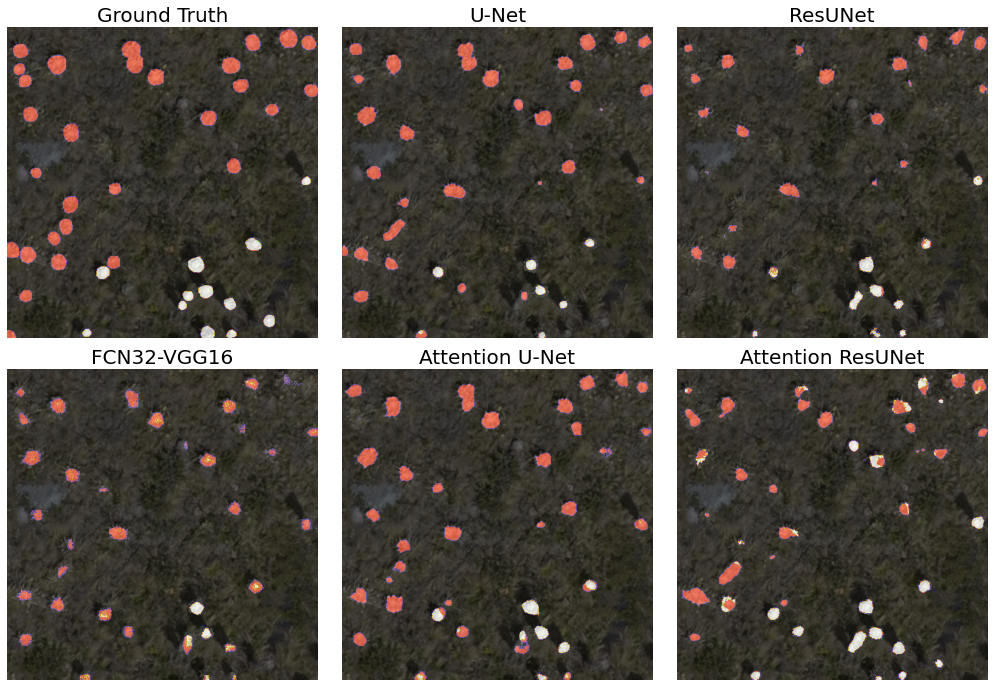

In [ ]:
# Tall and short image example (Image only)
from matplotlib.patches import Circle
index = u
fig, axs = plt.subplots(2, 3, figsize=(18,12))
axs[0,0].imshow(X_test[index][:,:,0:3])
axs[0,1].imshow(X_test[index][:,:,0:3])
axs[0,2].imshow(X_test[index][:,:,0:3])
axs[1,0].imshow(X_test[index][:,:,0:3])
axs[1,1].imshow(X_test[index][:,:,0:3])
axs[1,2].imshow(X_test[index][:,:,0:3])


axs[0,0].imshow(X_test[index][:,:,0:3])
#axs[1,0].imshow(y_test_all[index][:,:,0]+2*y_test_all[index][:,:,1])

z      = model_unet_kernel3.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)
zz     = model_attention_unet_kernel3.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)
zzz    = model_fcn32_kernel3.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)
zzzz   = model_resunet_kernel3.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)
zzzzz  = model_resaunet_kernel3.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)

axs[0,1].imshow(mask_gen(z), cmap='CMRmap_r', alpha=0.6)
axs[1,1].imshow(mask_gen(zz), cmap='CMRmap_r', alpha=0.6)
axs[1,0].imshow(mask_gen(zzz), cmap='CMRmap_r', alpha=0.6)
axs[0,2].imshow(mask_gen(zzzz), cmap='CMRmap_r', alpha=0.6)
axs[1,2].imshow(mask_gen(zzzzz), cmap='CMRmap_r', alpha=0.6)
axs[0,0].imshow(mask_gen(y_test_all[index]), cmap='CMRmap_r', alpha=0.6)

#axs[0,1].imshow(np.round(z), cmap='CMRmap_r', alpha=0.75)
#axs[1,1].imshow(np.round(zz), cmap='CMRmap_r', alpha=0.75)
#axs[1,0].imshow(np.round(zzz), cmap='CMRmap_r', alpha=0.75)
#axs[0,2].imshow(np.round(zzzz), cmap='CMRmap_r', alpha=0.75)
#axs[1,2].imshow(np.round(zzzzz), cmap='CMRmap_r', alpha=0.75)


# Remove axes
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')

axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')


# Set equal spacing
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')
axs[0,2].set_aspect('equal')

axs[1,0].set_aspect('equal')
axs[1,1].set_aspect('equal')
axs[1,2].set_aspect('equal')


# Set titles
axs[0,0].set_title('Ground Truth', size=20)
axs[1,0].set_title('FCN32-VGG16', size=20)
axs[0,1].set_title('U-Net', size=20)
axs[1,1].set_title('Attention U-Net', size=20)
axs[0,2].set_title('ResUNet', size=20)
axs[1,2].set_title('Attention ResUNet', size=20)


#fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig('tallshort-comparison.png', bbox_inches = 'tight', pad_inches = 0.1)

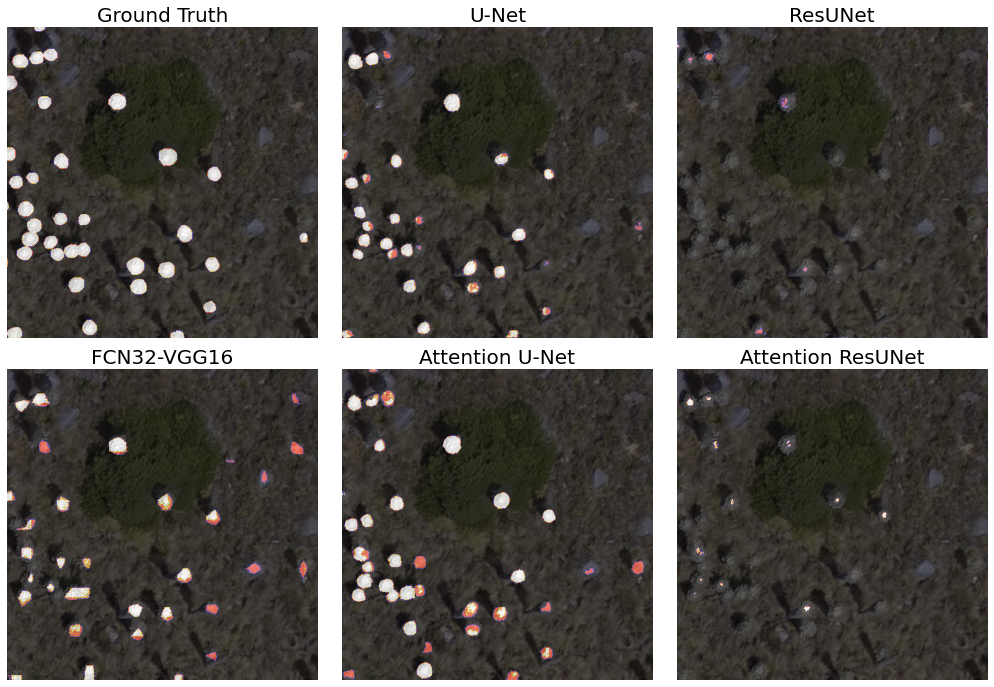

In [ ]:
# Tall image example
u = 2
from matplotlib.patches import Circle
index = u
fig, axs = plt.subplots(2, 3, figsize=(18,12))
axs[0,0].imshow(X_test[index][:,:,0:3])
axs[0,1].imshow(X_test[index][:,:,0:3])
axs[0,2].imshow(X_test[index][:,:,0:3])
axs[1,0].imshow(X_test[index][:,:,0:3])
axs[1,1].imshow(X_test[index][:,:,0:3])
axs[1,2].imshow(X_test[index][:,:,0:3])


axs[0,0].imshow(X_test[index][:,:,0:3])
#axs[1,0].imshow(y_test_all[index][:,:,0]+2*y_test_all[index][:,:,1])

z      = model_unet_dem_kernel3.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)
zz     = model_attention_unet_dem_kernel3.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)
zzz    = model_fcn32_dem_kernel3.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)
zzzz   = model_resunet_dem_kernel3.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)
zzzzz  = model_resaunet_dem_kernel3.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)

axs[0,1].imshow(mask_gen(z), cmap='CMRmap_r', alpha=0.6)
axs[1,1].imshow(mask_gen(zz), cmap='CMRmap_r', alpha=0.6)
axs[1,0].imshow(mask_gen(zzz), cmap='CMRmap_r', alpha=0.6)
axs[0,2].imshow(mask_gen(zzzz), cmap='CMRmap_r', alpha=0.6)
axs[1,2].imshow(mask_gen(zzzzz), cmap='CMRmap_r', alpha=0.6)
axs[0,0].imshow(mask_gen(y_test_all[index]), cmap='CMRmap_r', alpha=0.6)

#axs[0,1].imshow(np.round(z), cmap='gray', alpha=0.5)
#axs[1,1].imshow(np.round(zz), cmap='gray', alpha=0.5)
#axs[1,0].imshow(np.round(zzz), cmap='gray', alpha=0.5)
#axs[0,2].imshow(np.round(zzzz), cmap='gray', alpha=0.5)
#axs[1,2].imshow(np.round(zzzzz), cmap='gray', alpha=0.5)


#circle1 = Circle((160, 160), 60, fill=False, linewidth=4, alpha=0.5, color='red')
#circle2 = Circle((320, 170), 60, fill=False, linewidth=4, alpha=0.5, color='red')
#axs[5].add_artist(circle1)
#axs[5].add_artist(circle2)

# Remove axes
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')

axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')


# Set equal spacing
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')
axs[0,2].set_aspect('equal')

axs[1,0].set_aspect('equal')
axs[1,1].set_aspect('equal')
axs[1,2].set_aspect('equal')


# Set titles
axs[0,0].set_title('Ground Truth', size=20)
axs[1,0].set_title('FCN32-VGG16', size=20)
axs[0,1].set_title('U-Net', size=20)
axs[1,1].set_title('Attention U-Net', size=20)
axs[0,2].set_title('ResUNet', size=20)
axs[1,2].set_title('Attention ResUNet', size=20)


#fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig('tall-dem-comparison.png', bbox_inches = 'tight', pad_inches = 0.1)

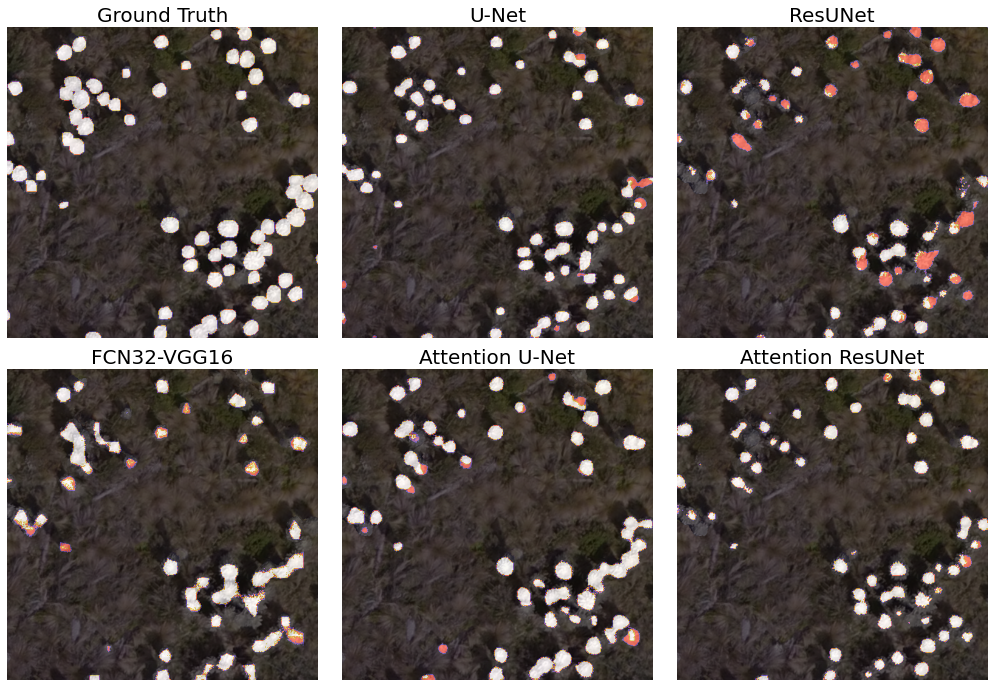

In [ ]:
# Tall and short image example (Image only)
from matplotlib.patches import Circle
index = u
fig, axs = plt.subplots(2, 3, figsize=(18,12))
axs[0,0].imshow(X_test[index][:,:,0:3])
axs[0,1].imshow(X_test[index][:,:,0:3])
axs[0,2].imshow(X_test[index][:,:,0:3])
axs[1,0].imshow(X_test[index][:,:,0:3])
axs[1,1].imshow(X_test[index][:,:,0:3])
axs[1,2].imshow(X_test[index][:,:,0:3])


axs[0,0].imshow(X_test[index][:,:,0:3])
#axs[1,0].imshow(y_test_all[index][:,:,0]+2*y_test_all[index][:,:,1])

z      = model_unet_kernel3.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)
zz     = model_attention_unet_kernel3.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)
zzz    = model_fcn32_kernel3.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)
zzzz   = model_resunet_kernel3.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)
zzzzz  = model_resaunet_kernel3.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)

axs[0,1].imshow(mask_gen(z), cmap='CMRmap_r', alpha=0.6)
axs[1,1].imshow(mask_gen(zz), cmap='CMRmap_r', alpha=0.6)
axs[1,0].imshow(mask_gen(zzz), cmap='CMRmap_r', alpha=0.6)
axs[0,2].imshow(mask_gen(zzzz), cmap='CMRmap_r', alpha=0.6)
axs[1,2].imshow(mask_gen(zzzzz), cmap='CMRmap_r', alpha=0.6)
axs[0,0].imshow(mask_gen(y_test_all[index]), cmap='CMRmap_r', alpha=0.6)

#axs[0,1].imshow(np.round(z), cmap='CMRmap_r', alpha=0.75)
#axs[1,1].imshow(np.round(zz), cmap='CMRmap_r', alpha=0.75)
#axs[1,0].imshow(np.round(zzz), cmap='CMRmap_r', alpha=0.75)
#axs[0,2].imshow(np.round(zzzz), cmap='CMRmap_r', alpha=0.75)
#axs[1,2].imshow(np.round(zzzzz), cmap='CMRmap_r', alpha=0.75)


# Remove axes
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')

axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')


# Set equal spacing
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')
axs[0,2].set_aspect('equal')

axs[1,0].set_aspect('equal')
axs[1,1].set_aspect('equal')
axs[1,2].set_aspect('equal')


# Set titles
axs[0,0].set_title('Ground Truth', size=20)
axs[1,0].set_title('FCN32-VGG16', size=20)
axs[0,1].set_title('U-Net', size=20)
axs[1,1].set_title('Attention U-Net', size=20)
axs[0,2].set_title('ResUNet', size=20)
axs[1,2].set_title('Attention ResUNet', size=20)


#fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig('tall-comparison.png', bbox_inches = 'tight', pad_inches = 0.1)

In [ ]:
print(score_eval(model_fcn32_kernel3, [n[:,:,0:3] for n in X_test], y_test_all))
print(score_eval(model_unet_kernel3, [n[:,:,0:3] for n in X_test], y_test_all))
print(score_eval(model_attention_unet_kernel3, [n[:,:,0:3] for n in X_test], y_test_all))
print(score_eval(model_resunet_kernel3, [n[:,:,0:3] for n in X_test], y_test_all))
print(score_eval(model_resaunet_kernel3, [n[:,:,0:3] for n in X_test], y_test_all))

In [ ]:
print(score_eval2(model_fcn32_dem_kernel3, [n[:,:,0:4] for n in X_test], y_test_all))
print(score_eval2(model_unet_dem_kernel3, [n[:,:,0:4] for n in X_test], y_test_all))
print(score_eval2(model_attention_unet_dem_kernel3, [n[:,:,0:4] for n in X_test], y_test_all))
print(score_eval2(model_resunet_dem_kernel3, [n[:,:,0:4] for n in X_test], y_test_all))
print(score_eval2(model_resaunet_dem_kernel3, [n[:,:,0:4] for n in X_test], y_test_all))

In [ ]:
print(score_eval_MULTI(model_fcn32_kernel3, [n[:,:,0:3] for n in X_test], y_test_all))
print(score_eval_MULTI(model_unet_kernel3, [n[:,:,0:3] for n in X_test], y_test_all))
print(score_eval_MULTI(model_attention_unet_kernel3, [n[:,:,0:3] for n in X_test], y_test_all))
print(score_eval_MULTI(model_resunet_kernel3, [n[:,:,0:3] for n in X_test], y_test_all))
print(score_eval_MULTI(model_resaunet_kernel3, [n[:,:,0:3] for n in X_test], y_test_all))

(0.9674717585245769, 0.9757210413614908, 0.9431927998860677)
(0.9827731450398763, 0.9729792277018229, 0.9719190597534181)
(0.97460142771403, 0.971048355102539, 0.9709081649780275)
(0.9775816599527997, 0.9726292292277019, 0.9582230250040689)
(0.9777930577596028, 0.9715283711751302, 0.9592885971069336)


In [ ]:
print(score_eval_MULTI2(model_fcn32_dem_kernel3, [n[:,:,0:4] for n in X_test], y_test_all))
print(score_eval_MULTI2(model_unet_dem_kernel3, [n[:,:,0:4] for n in X_test], y_test_all))
print(score_eval_MULTI2(model_attention_unet_dem_kernel3, [n[:,:,0:4] for n in X_test], y_test_all))
print(score_eval_MULTI2(model_resunet_dem_kernel3, [n[:,:,0:4] for n in X_test], y_test_all))
print(score_eval_MULTI2(model_resaunet_dem_kernel3, [n[:,:,0:4] for n in X_test], y_test_all))

(0.9674765268961589, 0.9757045110066732, 0.9432039260864258)
(0.977630933125814, 0.969882329305013, 0.9699646631876626)
(0.9806575775146485, 0.9769016901652018, 0.970707893371582)
(0.9698416392008464, 0.9672466913859049, 0.9537909825642903)
(0.7547213236490886, 0.9768699010213215, 0.7434886296590169)


In [ ]:
print(recall_eval_MULTI(model_fcn32_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_unet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_attention_unet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_resunet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_resaunet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0, 1.0)
(0.3486269998353645, 0.37562526740505997, 0.9826637830247453)
(0.3144102959245346, 0.19045699264991517, 0.989072986870398)
(0.27259406535313724, 0.030586503616901253, 0.9959622289399507)
(0.27315863387623257, 0.17254474725080032, 0.9868411913925392)


In [ ]:
print(recall_eval_MULTI(model_fcn32_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_unet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_attention_unet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_resunet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_resaunet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.00012206280922576101, 1.1740605531526526e-05, 0.9999861161473106)
(0.1860297820928688, 0.23571481253393353, 0.9925353540119092)
(0.26908202481812155, 0.26543294229487957, 0.9931352401238587)
(0.04766550015636785, 0.07092715852366675, 0.9960281771623253)
(0.40367553954275476, 0.04011557764237387, 0.764494239149877)


In [ ]:
print(precision_eval_MULTI(model_fcn32_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_unet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_attention_unet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_resunet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_resaunet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))

In [ ]:
print(precision_eval_MULTI(model_fcn32_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_unet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_attention_unet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_resunet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_resaunet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))

In [ ]:
print(f1_score_eval_MULTI(model_fcn32_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_unet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_attention_unet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_resunet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_resaunet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))

In [ ]:
print(f1_score_eval_MULTI(model_fcn32_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_unet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_attention_unet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_resunet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_resaunet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))

# Train models on images for short and tall plants (5x5 kernel)

## FCN32-VGG16

In [ ]:
# Train FCN32 with images
model_fcn32_kernel5 = fcn_32(input_size=(512,512,3), kernel_size = 5, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_fcn32_all = ModelCheckpoint('paramo-fcn32-kernel5.hdf5', monitor='val_accuracy',verbose=2, save_best_only=True)

model_fcn32_kernel5.fit(train_df_all, epochs=30, validation_data = validation_df_all, callbacks=[save_model_fcn32_all])



In [ ]:
# Train FCN32 with images + DEM
model_fcn32_dem_kernel5 = fcn_32(input_size=(512,512,4), kernel_size = 5, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_fcn32_dem_all = ModelCheckpoint('paramo-fcn32-dem-kernel5.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_fcn32_dem_kernel5.fit(train_dems_all_df, epochs=30, validation_data = validation_dems_all_df, callbacks=[save_model_fcn32_dem_all])

## U-Net

In [ ]:
# Train U-Net with images
model_unet_kernel5 = UNet(input_size=(512,512,3), kernel = 5, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_unet_all = ModelCheckpoint('paramo-unet-kernel5.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_unet_kernel5.fit(train_df_all, epochs=30, validation_data = validation_df_all, callbacks=[save_model_unet_all])



In [ ]:
# Train U-Net with images + DEM
model_unet_dem_kernel5 = UNet(input_size=(512,512,4), kernel = 5, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_unet_dem_all = ModelCheckpoint('paramo-unet-dem-kernel5.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_unet_dem_kernel5.fit(train_dems_all_df, epochs=30, validation_data = validation_dems_all_df, callbacks=[save_model_unet_dem_all])

## Attention U-Net

In [ ]:
# Train Attention U-Net with images
model_attention_unet_kernel5 = UNetAM(input_size=(512,512,3), kernel = 5, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_attention_unet_all = ModelCheckpoint('paramo-attention-unet-kernel5.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_attention_unet_kernel5.fit(train_df_all, epochs=30, validation_data = validation_df_all, callbacks=[save_model_attention_unet_all])



In [ ]:
# Train Attention U-Net with images + DEM
model_attention_unet_dem_kernel5 = UNet(input_size=(512,512,4), kernel = 5, lr = 0.0001, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy')
save_model_attention_unet_dem_all = ModelCheckpoint('paramo-attention-unet-dem-kernel5.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_attention_unet_dem_kernel5.fit(train_dems_all_df, epochs=30, validation_data = validation_dems_all_df, callbacks=[save_model_attention_unet_dem_all])

## ResUNet

In [ ]:
# Train ResUNet with images
model_resunet_kernel5 = res_unet(512, [64, 128, 256, 512], kernel_size = 5, num_channels = 3, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy',lr = 0.0001)
save_model_resunet_all = ModelCheckpoint('paramo-resunet-kernel5.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resunet_kernel5.fit(train_df_all, epochs=30, validation_data = validation_df_all, callbacks=[save_model_resunet_all])



In [ ]:
# Train ResUnet with images + DEM
model_resunet_dem_kernel5 = res_unet(512, [64, 128, 256, 512], kernel_size = 5, num_channels = 4, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy',lr = 0.0001)
save_model_resunet_dem_all = ModelCheckpoint('paramo-resunet-dem-kernel5.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resunet_dem_kernel5.fit(train_dems_all_df, epochs=30, validation_data = validation_dems_all_df, callbacks=[save_model_resunet_dem_all])

## Attention ResUNet

In [ ]:
# Train Attention ResUNet with images
model_resaunet_kernel5 = att_res_unet(512, [64, 128, 256, 512], kernel_size = 5, num_channels = 3, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy', lr = 0.0001)
save_model_resaunet_all = ModelCheckpoint('paramo-resaunet-kernel5.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resaunet_kernel5.fit(train_df_all, epochs=30, validation_data = validation_df_all, callbacks=[save_model_resaunet_all])



In [ ]:
# Train Attention ResUnet with images + DEM
model_resaunet_dem_kernel5 = res_unet(512, [64, 128, 256, 512], kernel_size = 5, num_channels = 4, num_classes = 3, num_out=3, out_layer = 'sigmoid', lossfunc='categorical_crossentropy', lr = 0.0001)
save_model_resaunet_dem_all = ModelCheckpoint('paramo-resaunet-dem-kernel5.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_resaunet_dem_kernel5.fit(train_dems_all_df, epochs=30, validation_data = validation_dems_all_df, callbacks=[save_model_resaunet_dem_all])

## Save models to Drive

In [ ]:
#!cp paramo-unet-kernel5.hdf5 drive/MyDrive/
#!cp paramo-attention-unet-kernel5.hdf5 drive/MyDrive/
#!cp paramo-fcn32-kernel5.hdf5 drive/MyDrive/
#!cp paramo-resunet-kernel5.hdf5 drive/MyDrive/
!cp paramo-resaunet-kernel5.hdf5 drive/MyDrive/

!cp paramo-unet-dem-kernel5.hdf5 drive/MyDrive/
!cp paramo-attention-unet-dem-kernel5.hdf5 drive/MyDrive/
#!cp paramo-fcn32-dem-kernel5.hdf5 drive/MyDrive/
!cp paramo-resunet-dem-kernel5.hdf5 drive/MyDrive/
!cp paramo-resaunet-dem-kernel5.hdf5 drive/MyDrive/

# Plots (5x5)

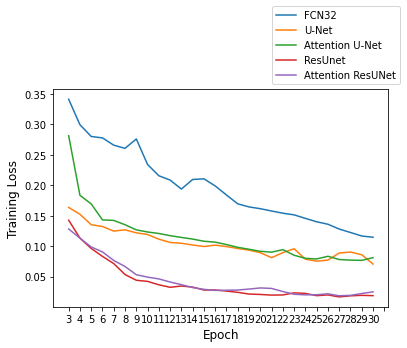

In [ ]:
plt.plot(model_fcn32_kernel5.history.history['loss'][2:])
plt.plot(model_unet_kernel5.history.history['loss'][2:])
plt.plot(model_attention_unet_kernel5.history.history['loss'][2:])
plt.plot(model_resunet_kernel5.history.history['loss'][2:])
plt.plot(model_resaunet_kernel5.history.history['loss'][2:])
'''plt.plot(fcn32_kernel3_loss[2:])
plt.plot(unet_kernel3_loss['loss'][2:])
plt.plot(attention_unet_kernel3_loss[2:])
plt.plot(resunet_kernel3_loss[2:])
plt.plot(resaunet_kernel3_loss[2:])'''
plt.ylabel('Training Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(range(0,29),range(3,31))
plt.legend(['FCN32', 'U-Net', 'Attention U-Net', 'ResUnet', 'Attention ResUNet'], bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-loss-image-kernel5.png', bbox_inches = 'tight')
plt.show()

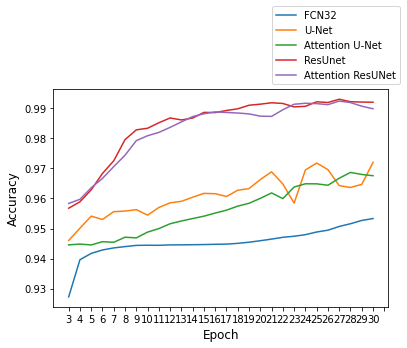

In [ ]:
plt.plot(model_fcn32_kernel5.history.history['accuracy'][2:])
plt.plot(model_unet_kernel5.history.history['accuracy'][2:])
plt.plot(model_attention_unet_kernel5.history.history['accuracy'][2:])
plt.plot(model_resunet_kernel5.history.history['accuracy'][2:])
plt.plot(model_resaunet_kernel5.history.history['accuracy'][2:])
plt.ylabel('Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(range(0,29),range(3,31))
plt.legend(['FCN32', 'U-Net', 'Attention U-Net', 'ResUnet', 'Attention ResUNet'], bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-accuracy-image-kernel5.png', bbox_inches = 'tight')
plt.show()

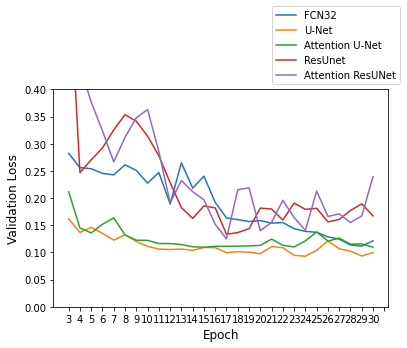

In [ ]:
plt.plot(model_fcn32_kernel5.history.history['val_loss'][2:])
plt.plot(model_unet_kernel5.history.history['val_loss'][2:])
plt.plot(model_attention_unet_kernel5.history.history['val_loss'][2:])
plt.plot(model_resunet_kernel5.history.history['val_loss'][2:])
plt.plot(model_resaunet_kernel5.history.history['val_loss'][2:])
'''plt.plot(fcn32_kernel3_loss[2:])
plt.plot(unet_kernel3_loss['loss'][2:])
plt.plot(attention_unet_kernel3_loss[2:])
plt.plot(resunet_kernel3_loss[2:])
plt.plot(resaunet_kernel3_loss[2:])'''
plt.ylabel('Validation Loss', size=12)
plt.ylim(0,0.4)
plt.xlabel('Epoch', size=12)
plt.xticks(range(0,29),range(3,31))
plt.legend(['FCN32', 'U-Net', 'Attention U-Net', 'ResUnet', 'Attention ResUNet'], bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-loss-image-kernel5.png', bbox_inches = 'tight')
plt.show()

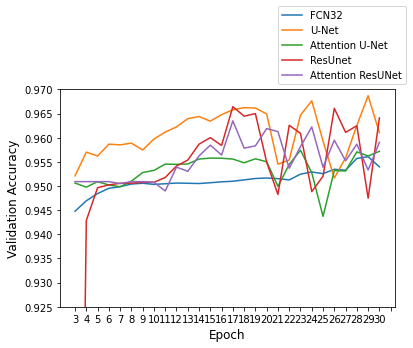

In [ ]:
plt.plot(model_fcn32_kernel5.history.history['val_accuracy'][2:])
plt.plot(model_unet_kernel5.history.history['val_accuracy'][2:])
plt.plot(model_attention_unet_kernel5.history.history['val_accuracy'][2:])
plt.plot(model_resunet_kernel5.history.history['val_accuracy'][2:])
plt.plot(model_resaunet_kernel5.history.history['val_accuracy'][2:])
plt.ylabel('Validation Accuracy', size=12)
plt.ylim(0.925, 0.97)
plt.xlabel('Epoch', size=12)
plt.xticks(range(0,29),range(3,31))
plt.legend(['FCN32', 'U-Net', 'Attention U-Net', 'ResUnet', 'Attention ResUNet'], bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-accuracy-image-kernel5.png', bbox_inches = 'tight')
plt.show()

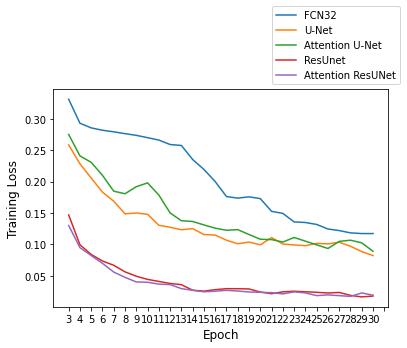

In [ ]:
plt.plot(model_fcn32_dem_kernel5.history.history['loss'][2:])
plt.plot(model_unet_dem_kernel5.history.history['loss'][2:])
plt.plot(model_attention_unet_dem_kernel5.history.history['loss'][2:])
plt.plot(model_resunet_dem_kernel5.history.history['loss'][2:])
plt.plot(model_resaunet_dem_kernel5.history.history['loss'][2:])
plt.ylabel('Training Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(range(0,29),range(3,31))
plt.legend(['FCN32', 'U-Net', 'Attention U-Net', 'ResUnet', 'Attention ResUNet'], bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-loss-image+dem-kernel5.png', bbox_inches = 'tight')
plt.show()

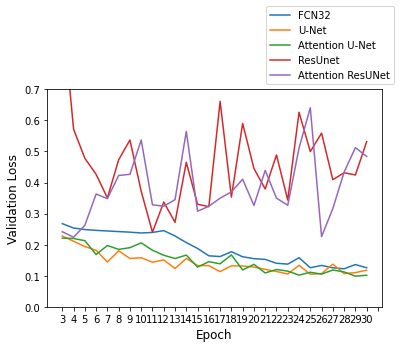

In [ ]:
plt.plot(model_fcn32_dem_kernel5.history.history['val_loss'][2:])
plt.plot(model_unet_dem_kernel5.history.history['val_loss'][2:])
plt.plot(model_attention_unet_dem_kernel5.history.history['val_loss'][2:])
plt.plot(model_resunet_dem_kernel5.history.history['val_loss'][2:])
plt.plot(model_resaunet_dem_kernel5.history.history['val_loss'][2:])
plt.ylabel('Validation Loss', size=12)
plt.ylim(0,0.7)
plt.xlabel('Epoch', size=12)
plt.xticks(range(0,29),range(3,31))
plt.legend(['FCN32', 'U-Net', 'Attention U-Net', 'ResUnet', 'Attention ResUNet'], bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-loss-image+dem-kernel5.png', bbox_inches = 'tight')
plt.show()

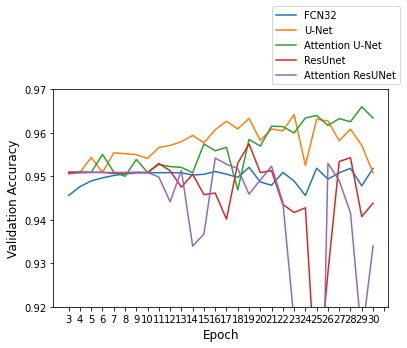

In [ ]:
plt.plot(model_fcn32_dem_kernel5.history.history['val_accuracy'][2:])
plt.plot(model_unet_dem_kernel5.history.history['val_accuracy'][2:])
plt.plot(model_attention_unet_dem_kernel5.history.history['val_accuracy'][2:])
plt.plot(model_resunet_dem_kernel5.history.history['val_accuracy'][2:])
plt.plot(model_resaunet_dem_kernel5.history.history['val_accuracy'][2:])
plt.ylabel('Validation Accuracy', size=12)
plt.ylim(0.92,0.97)
plt.xlabel('Epoch', size=12)
plt.xticks(range(0,29),range(3,31))
plt.legend(['FCN32', 'U-Net', 'Attention U-Net', 'ResUnet', 'Attention ResUNet'], bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-val-accuracy-image+dem-kernel5.png', bbox_inches = 'tight')
plt.show()

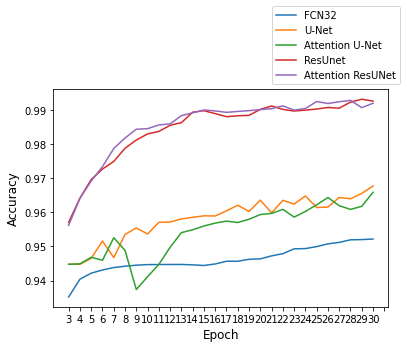

In [ ]:
plt.plot(model_fcn32_dem_kernel5.history.history['accuracy'][2:])
plt.plot(model_unet_dem_kernel5.history.history['accuracy'][2:])
plt.plot(model_attention_unet_dem_kernel5.history.history['accuracy'][2:])
plt.plot(model_resunet_dem_kernel5.history.history['accuracy'][2:])
plt.plot(model_resaunet_dem_kernel5.history.history['accuracy'][2:])
plt.ylabel('Accuracy', size=12)
plt.xlabel('Epoch', size=12)
plt.xticks(range(0,29),range(3,31))
plt.legend(['FCN32', 'U-Net', 'Attention U-Net', 'ResUnet', 'Attention ResUNet'], bbox_to_anchor=(1.05, 1), loc='lower right')
plt.savefig('model-training-accuracy-image+dem-kernel5.png', bbox_inches = 'tight')
plt.show()

#Model Comparison (5x5 kernel)

In [ ]:
model_fcn32_kernel5 = load_model('drive/MyDrive/paramo-fcn32-kernel5.hdf5')
model_unet_kernel5 = load_model('drive/MyDrive/paramo-unet-kernel5.hdf5')
model_attention_unet_kernel5 = load_model('drive/MyDrive/paramo-attention-unet-kernel5.hdf5')
model_resunet_kernel5 = load_model('drive/MyDrive/paramo-resunet-kernel5.hdf5')
model_resaunet_kernel5 = load_model('drive/MyDrive/paramo-resaunet-kernel5.hdf5')

model_fcn32_dem_kernel5 = load_model('drive/MyDrive/paramo-fcn32-dem-kernel5.hdf5')
model_unet_dem_kernel5 = load_model('drive/MyDrive/paramo-unet-dem-kernel5.hdf5')
model_attention_unet_dem_kernel5 = load_model('drive/MyDrive/paramo-attention-unet-dem-kernel5.hdf5')
model_resunet_dem_kernel5 = load_model('drive/MyDrive/paramo-resunet-dem-kernel5.hdf5')
model_resaunet_dem_kernel5 = load_model('drive/MyDrive/paramo-resaunet-dem-kernel5.hdf5')

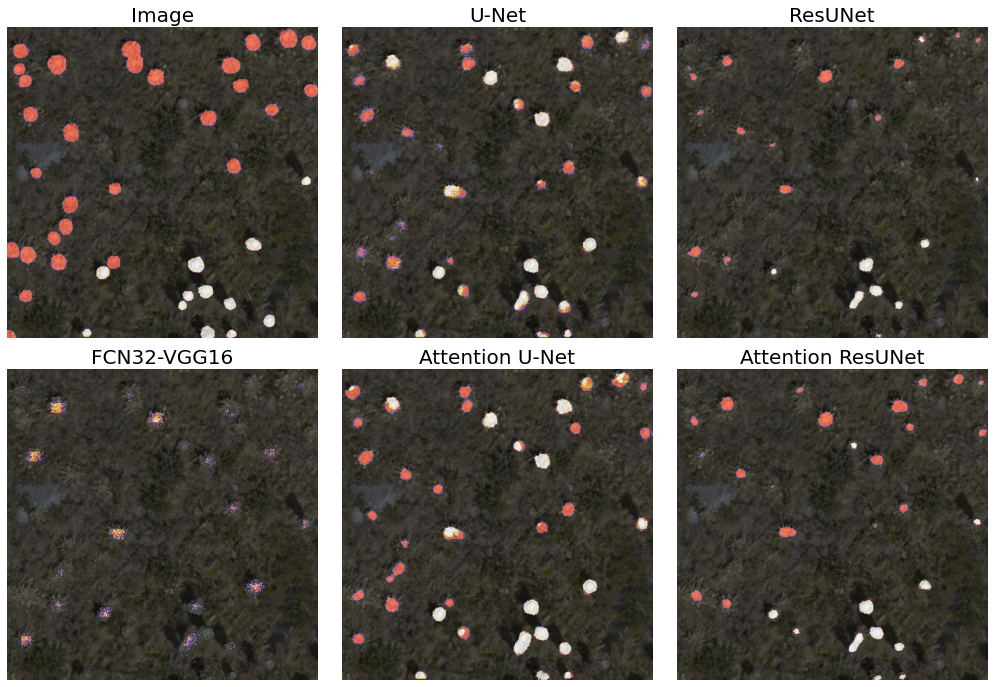

In [ ]:
# Tall and short image example
u = 8
from matplotlib.patches import Circle
index = u
fig, axs = plt.subplots(2, 3, figsize=(18,12))
axs[0,0].imshow(X_test[index][:,:,0:3])
axs[0,1].imshow(X_test[index][:,:,0:3])
axs[0,2].imshow(X_test[index][:,:,0:3])
axs[1,0].imshow(X_test[index][:,:,0:3])
axs[1,1].imshow(X_test[index][:,:,0:3])
axs[1,2].imshow(X_test[index][:,:,0:3])


axs[0,0].imshow(X_test[index][:,:,0:3])
#axs[1,0].imshow(y_test_all[index][:,:,0]+2*y_test_all[index][:,:,1])

z      = model_unet_dem_kernel5.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)
zz     = model_attention_unet_dem_kernel5.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)
zzz    = model_fcn32_dem_kernel5.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)
zzzz   = model_resunet_dem_kernel5.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)
zzzzz  = model_resaunet_dem_kernel5.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)

axs[0,1].imshow(mask_gen(z), cmap='CMRmap_r', alpha=0.6)
axs[1,1].imshow(mask_gen(zz), cmap='CMRmap_r', alpha=0.6)
axs[1,0].imshow(mask_gen(zzz), cmap='CMRmap_r', alpha=0.6)
axs[0,2].imshow(mask_gen(zzzz), cmap='CMRmap_r', alpha=0.6)
axs[1,2].imshow(mask_gen(zzzzz), cmap='CMRmap_r', alpha=0.6)
axs[0,0].imshow(mask_gen(y_test_all[index]), cmap='CMRmap_r', alpha=0.6)



# Remove axes
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')

axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')


# Set equal spacing
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')
axs[0,2].set_aspect('equal')

axs[1,0].set_aspect('equal')
axs[1,1].set_aspect('equal')
axs[1,2].set_aspect('equal')


# Set titles
axs[0,0].set_title('Image', size=20)
axs[1,0].set_title('FCN32-VGG16', size=20)
axs[0,1].set_title('U-Net', size=20)
axs[1,1].set_title('Attention U-Net', size=20)
axs[0,2].set_title('ResUNet', size=20)
axs[1,2].set_title('Attention ResUNet', size=20)


#fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig('tallshort-dem-comparison-kernel5.png', bbox_inches = 'tight', pad_inches = 0.1)

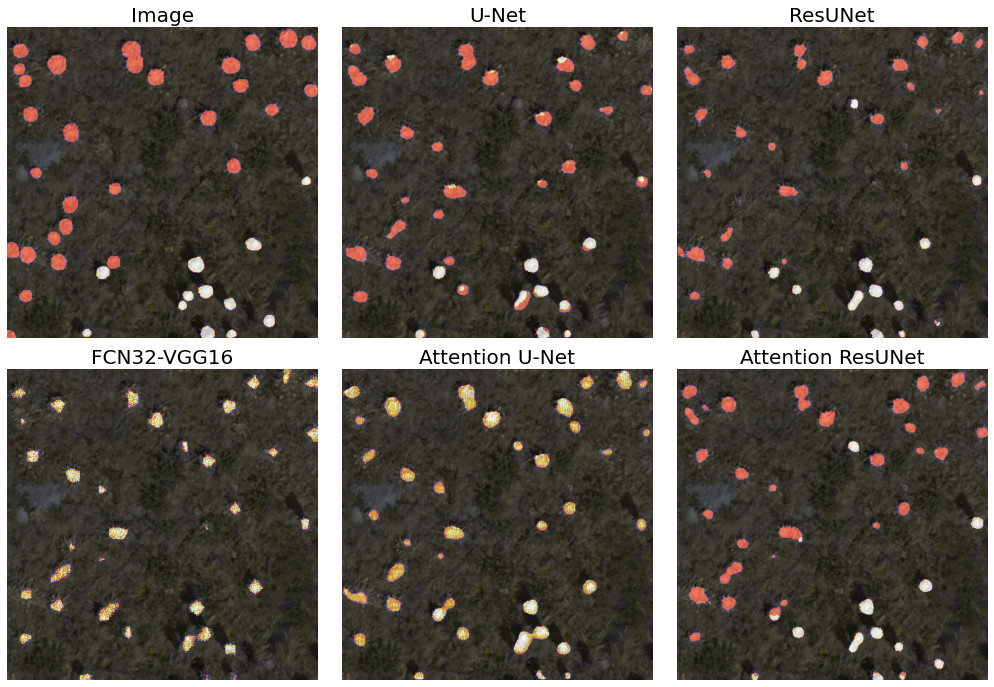

In [ ]:
# Tall and short image example (Image only)
from matplotlib.patches import Circle
index = u
fig, axs = plt.subplots(2, 3, figsize=(18,12))
axs[0,0].imshow(X_test[index][:,:,0:3])
axs[0,1].imshow(X_test[index][:,:,0:3])
axs[0,2].imshow(X_test[index][:,:,0:3])
axs[1,0].imshow(X_test[index][:,:,0:3])
axs[1,1].imshow(X_test[index][:,:,0:3])
axs[1,2].imshow(X_test[index][:,:,0:3])


axs[0,0].imshow(X_test[index][:,:,0:3])
#axs[1,0].imshow(y_test_all[index][:,:,0]+2*y_test_all[index][:,:,1])

z      = model_unet_kernel5.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)
zz     = model_attention_unet_kernel5.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)
zzz    = model_fcn32_kernel5.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)
zzzz   = model_resunet_kernel5.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)
zzzzz  = model_resaunet_kernel5.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)

axs[0,1].imshow(mask_gen(z), cmap='CMRmap_r', alpha=0.6)
axs[1,1].imshow(mask_gen(zz), cmap='CMRmap_r', alpha=0.6)
axs[1,0].imshow(mask_gen(zzz), cmap='CMRmap_r', alpha=0.6)
axs[0,2].imshow(mask_gen(zzzz), cmap='CMRmap_r', alpha=0.6)
axs[1,2].imshow(mask_gen(zzzzz), cmap='CMRmap_r', alpha=0.6)
axs[0,0].imshow(mask_gen(y_test_all[index]), cmap='CMRmap_r', alpha=0.6)



# Remove axes
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')

axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')


# Set equal spacing
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')
axs[0,2].set_aspect('equal')

axs[1,0].set_aspect('equal')
axs[1,1].set_aspect('equal')
axs[1,2].set_aspect('equal')


# Set titles
axs[0,0].set_title('Image', size=20)
axs[1,0].set_title('FCN32-VGG16', size=20)
axs[0,1].set_title('U-Net', size=20)
axs[1,1].set_title('Attention U-Net', size=20)
axs[0,2].set_title('ResUNet', size=20)
axs[1,2].set_title('Attention ResUNet', size=20)


#fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig('tallshort-comparison-kernel5.png', bbox_inches = 'tight', pad_inches = 0.1)

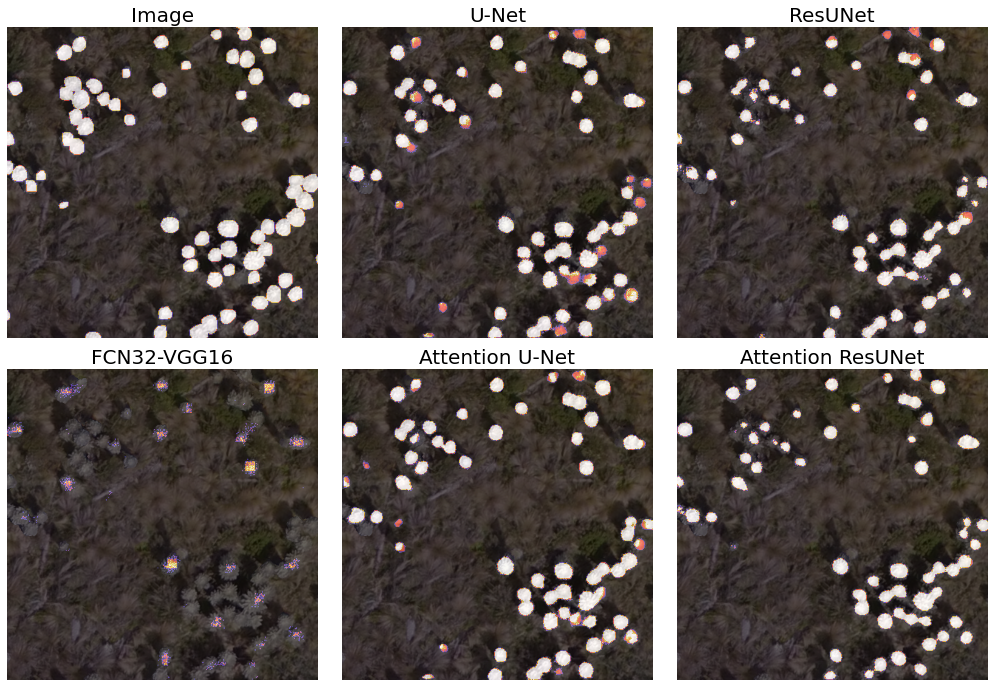

In [ ]:
# Tall and short image example
u = 1
from matplotlib.patches import Circle
index = u
fig, axs = plt.subplots(2, 3, figsize=(18,12))
axs[0,0].imshow(X_test[index][:,:,0:3])
axs[0,1].imshow(X_test[index][:,:,0:3])
axs[0,2].imshow(X_test[index][:,:,0:3])
axs[1,0].imshow(X_test[index][:,:,0:3])
axs[1,1].imshow(X_test[index][:,:,0:3])
axs[1,2].imshow(X_test[index][:,:,0:3])


axs[0,0].imshow(X_test[index][:,:,0:3])
#axs[1,0].imshow(y_test_all[index][:,:,0]+2*y_test_all[index][:,:,1])

z      = model_unet_dem_kernel5.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)
zz     = model_attention_unet_dem_kernel5.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)
zzz    = model_fcn32_dem_kernel5.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)
zzzz   = model_resunet_dem_kernel5.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)
zzzzz  = model_resaunet_dem_kernel5.predict(X_test[index].reshape(1,512,512,4)).reshape(512,512,3)

axs[0,1].imshow(mask_gen(z), cmap='CMRmap_r', alpha=0.6)
axs[1,1].imshow(mask_gen(zz), cmap='CMRmap_r', alpha=0.6)
axs[1,0].imshow(mask_gen(zzz), cmap='CMRmap_r', alpha=0.6)
axs[0,2].imshow(mask_gen(zzzz), cmap='CMRmap_r', alpha=0.6)
axs[1,2].imshow(mask_gen(zzzzz), cmap='CMRmap_r', alpha=0.6)
axs[0,0].imshow(mask_gen(y_test_all[index]), cmap='CMRmap_r', alpha=0.6)



# Remove axes
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')

axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')


# Set equal spacing
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')
axs[0,2].set_aspect('equal')

axs[1,0].set_aspect('equal')
axs[1,1].set_aspect('equal')
axs[1,2].set_aspect('equal')


# Set titles
axs[0,0].set_title('Image', size=20)
axs[1,0].set_title('FCN32-VGG16', size=20)
axs[0,1].set_title('U-Net', size=20)
axs[1,1].set_title('Attention U-Net', size=20)
axs[0,2].set_title('ResUNet', size=20)
axs[1,2].set_title('Attention ResUNet', size=20)


#fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig('tall-dem-comparison-kernel5.png', bbox_inches = 'tight', pad_inches = 0.1)

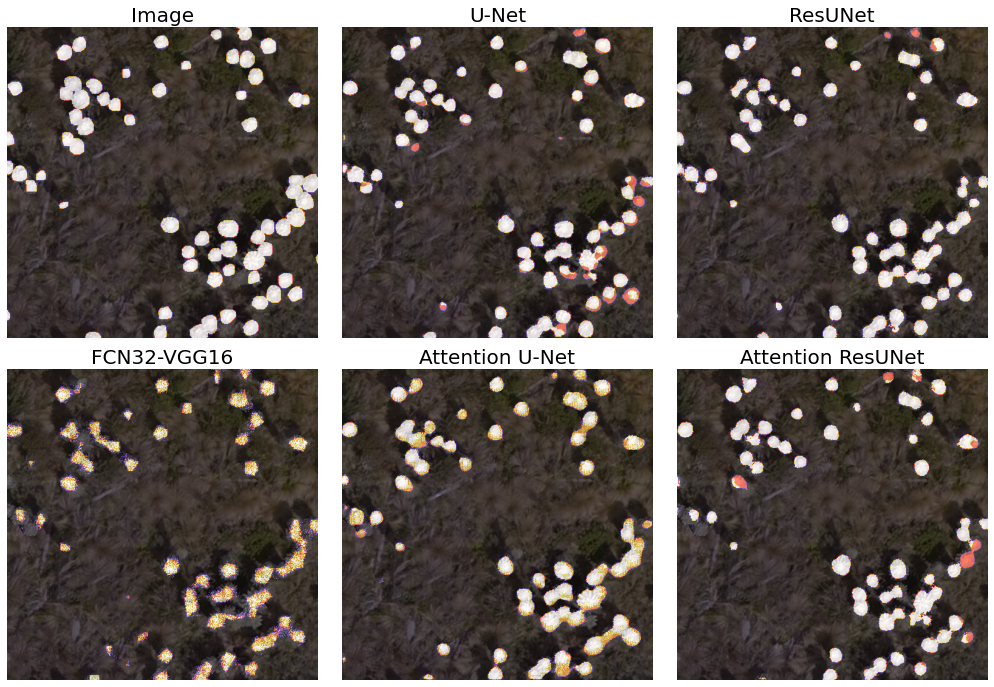

In [ ]:
# Tall and short image example (Image only)
from matplotlib.patches import Circle
index = u
fig, axs = plt.subplots(2, 3, figsize=(18,12))
axs[0,0].imshow(X_test[index][:,:,0:3])
axs[0,1].imshow(X_test[index][:,:,0:3])
axs[0,2].imshow(X_test[index][:,:,0:3])
axs[1,0].imshow(X_test[index][:,:,0:3])
axs[1,1].imshow(X_test[index][:,:,0:3])
axs[1,2].imshow(X_test[index][:,:,0:3])


axs[0,0].imshow(X_test[index][:,:,0:3])
#axs[1,0].imshow(y_test_all[index][:,:,0]+2*y_test_all[index][:,:,1])

z      = model_unet_kernel5.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)
zz     = model_attention_unet_kernel5.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)
zzz    = model_fcn32_kernel5.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)
zzzz   = model_resunet_kernel5.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)
zzzzz  = model_resaunet_kernel5.predict(X_test[index].reshape(1,512,512,4)[:,:,:,0:3]).reshape(512,512,3)

axs[0,1].imshow(mask_gen(z), cmap='CMRmap_r', alpha=0.6)
axs[1,1].imshow(mask_gen(zz), cmap='CMRmap_r', alpha=0.6)
axs[1,0].imshow(mask_gen(zzz), cmap='CMRmap_r', alpha=0.6)
axs[0,2].imshow(mask_gen(zzzz), cmap='CMRmap_r', alpha=0.6)
axs[1,2].imshow(mask_gen(zzzzz), cmap='CMRmap_r', alpha=0.6)
axs[0,0].imshow(mask_gen(y_test_all[index]), cmap='CMRmap_r', alpha=0.6)



# Remove axes
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')

axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')


# Set equal spacing
axs[0,0].set_aspect('equal')
axs[0,1].set_aspect('equal')
axs[0,2].set_aspect('equal')

axs[1,0].set_aspect('equal')
axs[1,1].set_aspect('equal')
axs[1,2].set_aspect('equal')


# Set titles
axs[0,0].set_title('Image', size=20)
axs[1,0].set_title('FCN32-VGG16', size=20)
axs[0,1].set_title('U-Net', size=20)
axs[1,1].set_title('Attention U-Net', size=20)
axs[0,2].set_title('ResUNet', size=20)
axs[1,2].set_title('Attention ResUNet', size=20)


#fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig('tall-comparison-kernel5.png', bbox_inches = 'tight', pad_inches = 0.1)

#Metrics

In [ ]:
print(recall_eval_MULTI(model_fcn32_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_unet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_attention_unet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_resunet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_resaunet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))

(0.5050310614011433, 0.7277305963856802, 0.9940651530689939)
(0.5897010074505964, 0.8265456602795793, 0.9944507344536705)
(0.6764332213956294, 0.8132600644333983, 0.9902363039407761)
(0.4697853313520003, 0.6160050093375496, 0.9979024727124014)
(0.5335686453225007, 0.7008330148154847, 0.9966920055567591)


In [ ]:
print(recall_eval_MULTI(model_fcn32_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_unet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_attention_unet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_resunet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_resaunet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))

(0.5701176898893697, 0.6452464468857032, 0.9935079512230526)
(0.6586988256288508, 0.5766501614306707, 0.9972904149587922)
(0.670355218910816, 0.7118652303977605, 0.9916243232155214)
(0.38714516257254317, 0.5234155656023524, 0.9949677323248021)
(0.40951877930390435, 0.5368110843357196, 0.9993132641687703)


In [ ]:
print(precision_eval_MULTI(model_fcn32_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_unet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_attention_unet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_resunet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_resaunet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))

(0.5213233549011247, 0.38857744164065466, 0.9702108726161472)
(0.9767159765318998, 0.40439066310965, 0.9746614785267849)
(0.6616704592350694, 0.38244964798648395, 0.9804832489937817)
(0.8822599005930377, 0.4398526230849976, 0.9628212005735337)
(0.5795414337656536, 0.5070098825654367, 0.9658070052115703)


In [ ]:
print(precision_eval_MULTI(model_fcn32_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_unet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_attention_unet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_resunet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_resaunet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))

(0.486588819811164, 0.36443142371018566, 0.9677262429000602)
(0.5559964460848602, 0.4374683042288169, 0.9670712763634848)
(0.7480714454510063, 0.38949215041503404, 0.9774789638252606)
(0.6073773867917033, 0.2981877258025333, 0.9550948949316315)
(0.817907420526849, 0.6007091154103354, 0.952137394370972)


In [ ]:
print(f1_score_eval_MULTI(model_fcn32_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_unet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_attention_unet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_resunet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_resaunet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))

(0.2543257384939656, 0.2861031626622122, 0.9819745100916859)
(0.6960284703088048, 0.36097622753168457, 0.9844264501119238)
(0.4957823695840723, 0.3442203163400236, 0.9853196149864143)
(0.4568935366949068, 0.17787986580730525, 0.9800203896867605)
(0.255583585770019, 0.3392157976400916, 0.9809685235694481)


In [ ]:
print(f1_score_eval_MULTI(model_fcn32_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_unet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_attention_unet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_resunet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_resaunet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))

(0.3084290113422914, 0.20702816786197814, 0.980412380101347)
(0.40572635525773504, 0.12168542750761047, 0.9819079208108408)
(0.5841917309398422, 0.26431862146074764, 0.9844609687496859)
(0.3370956671257649, 0.0420730485352095, 0.9744845338218265)
(0.4453781901049668, 0.23097559835077028, 0.9751054456148402)


In [ ]:
print(recall_eval_MULTI(model_fcn32_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_unet_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_attention_unet_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_resunet_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_resaunet_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))

(0.5398861668801437, 0.5595922372247938, 0.9945906574669146)
(0.715846771091782, 0.813008497951624, 0.9906977560041414)
(0.7011515806567742, 0.6559185940329976, 0.9872568996880835)
(0.6420127714621365, 0.657376354897508, 0.995898640521629)
(0.571889082481866, 0.7219893471318801, 0.9954405223219326)


In [ ]:
print(recall_eval_MULTI(model_fcn32_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_unet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_attention_unet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_resunet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(recall_eval_MULTI(model_resaunet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))

(0.36313298229942187, 0.5176507028485482, 0.9990333533817324)
(0.6847952478357793, 0.6673720505435742, 0.9928638576504963)
(0.747291775928225, 0.6512864914070707, 0.9919933492846861)
(0.4474619331217397, 0.5559938814025811, 0.9978707248495675)
(0.4746524681875442, 0.6444495991669387, 0.9940774862858989)


In [ ]:
print(precision_eval_MULTI(model_fcn32_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_unet_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_attention_unet_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_resunet_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_resaunet_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))

(0.4494295121949483, 0.3719628133994628, 0.9672717705249819)
(0.5680365368236473, 0.3897253574397277, 0.9820280253586069)
(0.4405141723327961, 0.3637022585160041, 0.9808387558176339)
(0.6816575389070958, 0.4494890909726533, 0.9682099938348793)
(0.6744536066149298, 0.4256909863318409, 0.9668596523021961)


In [ ]:
print(precision_eval_MULTI(model_fcn32_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_unet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_attention_unet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_resunet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(precision_eval_MULTI(model_resaunet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))

(0.4436899607800591, 0.38611750796136607, 0.9474402274215308)
(0.49595178259831785, 0.39236677377575263, 0.9757508698610861)
(0.4972990904633258, 0.40181181378398456, 0.9762852807497038)
(0.9731296106000419, 0.7298984208410895, 0.9589142783035092)
(0.7206889023568919, 0.4213075826581127, 0.9640932301741723)


In [ ]:
print(f1_score_eval_MULTI(model_fcn32_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_unet_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_attention_unet_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_resunet_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_resaunet_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))

(0.26581829626371245, 0.10244971803748161, 0.9807252256059846)
(0.4548787519620773, 0.346945404911349, 0.9863370389149914)
(0.38351742968213215, 0.2180294546536171, 0.9840183331780297)
(0.46239373492284347, 0.22128766860774884, 0.981838718158522)
(0.38074635160931136, 0.28367533804055095, 0.980883814818908)


In [ ]:
print(f1_score_eval_MULTI(model_fcn32_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_unet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_attention_unet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_resunet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(f1_score_eval_MULTI(model_resaunet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))

(0.0537513155435322, 0.033652583362748206, 0.9724669687636257)
(0.40205389503311756, 0.23414561281075064, 0.9842193472075861)
(0.4444470967193224, 0.21049556234366115, 0.9840513157657003)
(0.49138437058257983, 0.34247432977583686, 0.977950601211029)
(0.356196273277008, 0.27304747747118063, 0.9787993212198028)


In [ ]:
print(sum(score_eval(model_fcn32_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))/12)
print(sum(score_eval(model_unet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))/12)
print(sum(score_eval(model_attention_unet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))/12)
print(sum(score_eval(model_resunet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))/12)
print(sum(score_eval(model_resaunet_kernel3, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))/12)

0.9724858601888022
0.9785811106363931
0.9789691501193576
0.9687237209743923
0.9734725952148436


In [ ]:
print(sum(score_eval2(model_fcn32_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))/12)
print(sum(score_eval2(model_unet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))/12)
print(sum(score_eval2(model_attention_unet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))/12)
print(sum(score_eval2(model_resunet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))/12)
print(sum(score_eval2(model_resaunet_dem_kernel3, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))/12)

0.9707175360785589
0.9746475219726561
0.9760829077826606
0.9613433414035374
0.9653127458360459


In [ ]:
print(sum(score_eval(model_fcn32_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))/12)
print(sum(score_eval(model_unet_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))/12)
print(sum(score_eval(model_attention_unet_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))/12)
print(sum(score_eval(model_resunet_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))/12)
print(sum(score_eval(model_resaunet_kernel5, [n[:,:,0:3].reshape(1,512,512,3) for n in X_test], y_test_all))/12)

0.9677844577365451
0.9797420501708983
0.9717229207356772
0.9749626583523221
0.9746892717149523


In [ ]:
print(sum(score_eval2(model_fcn32_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))/12)
print(sum(score_eval2(model_unet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))/12)
print(sum(score_eval2(model_attention_unet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))/12)
print(sum(score_eval2(model_resunet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))/12)
print(sum(score_eval2(model_resaunet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))/12)

0.9630730946858722
0.975306193033854
0.9763925340440539
0.9673985375298394
0.9688330756293405


In [ ]:
print(score_eval2(model_unet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))
print(score_eval2(model_attention_unet_dem_kernel5, [n[:,:,0:4].reshape(1,512,512,4) for n in X_test], y_test_all))

[0.0639190673828125, 0.1127777099609375, 0.054828643798828125, 0.04242706298828125, 0.0552978515625, 0.038604736328125, 0.0, 0.007884979248046875, 0.01404571533203125, 0.0, 0.0, 0.0]
[0.0639190673828125, 0.1127777099609375, 0.054828643798828125, 0.04242706298828125, 0.0552978515625, 0.038604736328125, 0.0, 0.007884979248046875, 0.01404571533203125, 0.0, 0.0, 0.0]
